<a href="https://colab.research.google.com/github/embarced/notebooks/blob/master/deep/intro-classification-2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification

_Based on given examples learn a function that can categorize a set of data into classes._

_Objective: classify data having an unknown prediction_

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.__version__

'2.7.0'

In [2]:
tf.random.set_seed(42)

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20

figsize_3d = (12, 12)

In [5]:
font_size=15
title_font_size=25

In [6]:
!pip install colour

In [7]:
# %config InlineBackend.figure_format = 'svg'

In [8]:
#@title Hidden code for plotting of decision boundaries taken from dtreeviz
# copied and adapted from
# https://github.com/parrt/dtreeviz/blob/class-boundary-viz/dtreeviz/classifiers.py
# need to use lib after changes have been merged

import numpy as np
import pandas as pd

import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from colour import Color
from PIL import ImageColor

YELLOW = '#fefecd'
GREEN = '#cfe2d4'
DARKBLUE = '#313695'
BLUE = '#4575b4'
DARKGREEN = '#006400'
LIGHTORANGE = '#fee090'
LIGHTBLUE = '#a6bddb'
GREY = '#444443'
WEDGE_COLOR = GREY
CATEGORICAL_SPLIT_LEFT= '#FFC300'
CATEGORICAL_SPLIT_RIGHT = BLUE

HIGHLIGHT_COLOR = '#D67C03'

color_blind_friendly_colors = [
    None,  # 0 classes
    None,  # 1 class
    ['#FEFEBB', '#a1dab4'],  # 2 classes
    ['#FEFEBB', '#D9E6F5', '#a1dab4'],  # 3 classes
    ['#FEFEBB', '#D9E6F5', '#a1dab4', LIGHTORANGE],  # 4
    ['#FEFEBB', '#D9E6F5', '#a1dab4', '#41b6c4', LIGHTORANGE],  # 5
    ['#FEFEBB', '#c7e9b4', '#41b6c4', '#2c7fb8', LIGHTORANGE, '#f46d43'],  # 6
    ['#FEFEBB', '#c7e9b4', '#7fcdbb', '#41b6c4', '#225ea8', '#fdae61', '#f46d43'],  # 7
    ['#FEFEBB', '#edf8b1', '#c7e9b4', '#7fcdbb', '#1d91c0', '#225ea8', '#fdae61', '#f46d43'],  # 8
    ['#FEFEBB', '#c7e9b4', '#41b6c4', '#74add1', BLUE, DARKBLUE, LIGHTORANGE, '#fdae61', '#f46d43'],  # 9
    ['#FEFEBB', '#c7e9b4', '#41b6c4', '#74add1', BLUE, DARKBLUE, LIGHTORANGE, '#fdae61', '#f46d43', '#d73027']  # 10
]

COLORS = {'scatter_edge': GREY,
          'scatter_marker': BLUE,
          'scatter_marker_alpha': 0.7,
          'class_boundary' : GREY,
          'warning' : '#E9130D',
          'tile_alpha':0.8,            # square tiling in clfviz to show probabilities
          'tesselation_alpha': 0.3,    # rectangular regions for decision tree feature space partitioning
          'tesselation_alpha_3D': 0.5,
          'split_line': GREY,
          'mean_line': '#f46d43',
          'axis_label': GREY,
          'title': GREY,
          'legend_title': GREY,
          'legend_edge': GREY,
          'edge': GREY,
          'color_map_min': '#c7e9b4',
          'color_map_max': '#081d58',
          'classes': color_blind_friendly_colors,
          'rect_edge': GREY,
          'text': GREY,
          'highlight': HIGHLIGHT_COLOR,
          'wedge': WEDGE_COLOR,
          'text_wedge': WEDGE_COLOR,
          'arrow': GREY,
          'node_label': GREY,
          'tick_label': GREY,
          'leaf_label': GREY,
          'pie': GREY,
          'hist_bar': LIGHTBLUE,
          'categorical_split_left': CATEGORICAL_SPLIT_LEFT,
          'categorical_split_right': CATEGORICAL_SPLIT_RIGHT
          }


def adjust_colors(colors):
    if colors is None:
        return COLORS
    return dict(COLORS, **colors)

import numpy as np
import pandas as pd

import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from colour import Color
from PIL import ImageColor

def clfviz_bivar(model, X:np.ndarray, y:np.ndarray,
                 ntiles=50, tile_fraction=.9,
                 binary_threshold=0.5,
                 show=['instances','boundaries','probabilities','misclassified'], # also 'legend'
                 feature_names=None, target_name=None, class_names=None,
                 markers=None,
                 boundary_marker='o', boundary_markersize=.8,
                 fontsize=9, fontname="Arial",
                 dot_w=25, colors:dict=None,
                 ax=None) -> None:
    """
    See comment and parameter descriptions for clfviz() above.
    """
    if isinstance(X, pd.DataFrame):
        X = X.values
    if isinstance(y, pd.Series):
        y = y.values

    if len(X.shape)==1 or (len(X.shape)==2 and X.shape[1]!=2) or len(X.shape)>2:
        raise ValueError(f"Expecting 2D data not {X.shape}")

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 3.5))

    # Created grid over the range of x1 and x2 variables, get probabilities, predictions
    grid_points, grid_proba, grid_pred_as_matrix, w, x_, class_X, class_values = \
        _compute_tiling(model, X, y, binary_threshold, ntiles, tile_fraction)

    x_proba = _predict_proba(model, X)
    if len(np.unique(y)) == 2:  # is k=2 binary?
        X_pred = np.where(x_proba[:, 1] >= binary_threshold, 1, 0)
    else:
        X_pred = np.argmax(x_proba, axis=1)  # TODO: assumes classes are 0..k-1
    class_X_pred = [X_pred[y == cl] for cl in class_values]

    if markers is None:
        markers = ['o']*len(class_X)

    colors = adjust_colors(colors)

    class_values = np.unique(y) # returns sorted

    # Get class to color map for probabilities and predictions
    color_map, grid_pred_colors, grid_proba_colors = \
        _get_grid_colors(grid_proba, grid_pred_as_matrix, class_values, colors)

    # Draw probabilities or class prediction grid
    facecolors = grid_proba_colors if 'probabilities' in show else grid_pred_colors
    _draw_tiles(ax, grid_points, facecolors, colors['tile_alpha'], x_, w)

    # Get grid with class predictions with coordinates (x,y)
    # e.g., y_pred[0,0] is lower left pixel and y_pred[5,5] is top-right pixel
    # for npoints=5
    grid_pred_as_matrix = grid_pred_as_matrix.reshape(ntiles, ntiles)

    if 'boundaries' in show:
        _draw_boundary_edges(ax, grid_points, grid_pred_as_matrix,
                             boundary_marker, boundary_markersize,
                             colors, w, x_)

    # Draw the X instances circles
    if 'instances' in show:
        for i, x_ in enumerate(class_X):
            if 'misclassified' in show:
                # Show correctly classified markers
                good_x = x_[class_X_pred[i] == class_values[i],:]
                ax.scatter(good_x[:, 0], good_x[:, 1],
                           s=dot_w, c=color_map[i],
                           marker=markers[i],
                           alpha=colors['scatter_marker_alpha'],
                           edgecolors=colors['scatter_edge'],
                           lw=.5)
                # Show misclassified markers (can't have alpha per marker so do in 2 calls)
                bad_x = x_[class_X_pred[i] != class_values[i],:]
                ax.scatter(bad_x[:, 0], bad_x[:, 1],
                           s=dot_w, c=color_map[i],
                           marker=markers[i],
                           alpha=1.0,
                           edgecolors=colors['warning'],
                           lw=.5)
            else:
                ax.scatter(x_[:, 0], x_[:, 1],
                           s=dot_w, c=color_map[i],
                           marker=markers[i],
                           alpha=colors['scatter_marker_alpha'],
                           edgecolors=colors['scatter_edge'],
                           lw=.5)

    if feature_names is not None:
        ax.set_xlabel(f"{feature_names[0]}", fontsize=fontsize, fontname=fontname, color=colors['axis_label'])
        ax.set_ylabel(f"{feature_names[1]}", fontsize=fontsize, fontname=fontname, color=colors['axis_label'])

    if 'legend' in show:
        class_names = utils._normalize_class_names(class_names, nclasses=len(class_values))
        add_classifier_legend(ax, class_names, class_values, color_map, target_name, colors)

    ax.tick_params(axis='both', which='major', width=.3, labelcolor=colors['tick_label'],
                   labelsize=fontsize)
    for tick in ax.get_xticklabels():
        tick.set_fontname(fontname)
    for tick in ax.get_yticklabels():
        tick.set_fontname(fontname)
    ax.spines['top'].set_visible(False)  # turns off the top "spine" completely
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(.5)
    ax.spines['bottom'].set_linewidth(.5)

def _compute_tiling(model, X:np.ndarray, y:np.ndarray, binary_threshold,
                    ntiles, tile_fraction):
    """
    Create grid over the range of x1 and x2 variables; use the model to
    compute the probabilities with model.predict_proba(), which will work with sklearn
    and, I think, XGBoost. Later we will have to figure out how to get probabilities
    out of the other models we support.

    The predictions are computed simply by picking the argmax of probabilities, which
    assumes classes are 0..k-1. TODO: update to allow disjoint integer class values

    For k=2 binary classifications, there is no way to set the threshold and so
    a threshold of 0.5 is implicitly chosen by argmax.

    This returns all of the details needed to plot the tiles. The coordinates of
    the grid are a linear space from min to max of each variable, inclusively.
    So if the range is 1..5 and we want 5 tiles, then the width of each tile is 1.
    We get a tile at each position. When we are drawing, the position is taken as
    the center of the tile. In this case, the grid points would be centered over
    1,2,3,4, and 5.
    """
    if isinstance(X, pd.DataFrame):
        X = X.values
    if isinstance(y, pd.Series):
        y = y.values

    X1 = X[:, 0]
    X2 = X[:, 1]
    x1r = max(X1) - min(X1)
    x2r = max(X2) - min(X2)
    border1 = x1r*0.05 # make a 5% border
    border2 = x2r*0.05
    x1range = (min(X1)-border1, max(X1)+border1)
    x2range = (min(X2)-border2, max(X2)+border2)
    w = (x1r+2*border1) / (ntiles-1)
    h = (x2r+2*border2) / (ntiles-1)
    w *= tile_fraction
    h *= tile_fraction

    grid_points = []  # a list of coordinate pairs for the grid
    # Iterate through v1 (x-axis) most quickly then v2 (y-axis)
    for iv2, v2 in enumerate(np.linspace(*x2range, num=ntiles, endpoint=True)):
        for iv1, v1 in enumerate(np.linspace(*x1range, num=ntiles, endpoint=True)):
            grid_points.append([v1, v2])
    grid_points = np.array(grid_points)

    class_values = np.unique(y)
    class_X = [X[y == cl] for cl in class_values]

    grid_proba = _predict_proba(model, grid_points)

    if len(np.unique(y))==2: # is k=2 binary?
        grid_pred = np.where(grid_proba[:,1]>=binary_threshold,1,0)
    else:
        grid_pred = np.argmax(grid_proba, axis=1) # TODO: assumes classes are 0..k-1

    return grid_points, grid_proba, grid_pred, w, h, class_X, class_values


def _get_grid_colors(grid_proba, grid_pred, class_values, colors):
    """
    For the grid locations, return a list of colors, one per location
    indicating the class color.  To compute the probability color,
    we want to simulate overlaying regions from multiple trees onto
    the two-dimensional feature space using alpha to shade the colors.
    Instead, compute the color for each tile by combining the class colors
    according to their probabilities. If class 1 has probability .3 and class 2
    has probability .7, multiply the color ((R,G,B) color vector) associated
    with class 1 by .3 and the color vector associated with class 2 by .7 then
    add together. This gives a weighted color vector for each tile associated with
    the class probabilities. This gives the exact same effect as alpha channels,
    but transparent colors screwed up plotting the instance circles on top; they
    got washed out. This gives us more control and we can use alpha=1.
    """
    nclasses = len(class_values)
    class_colors = np.array(colors['classes'][nclasses])

    grid_pred_colors = class_colors[grid_pred] # color for each prediction in grid

    color_map = {v: class_colors[i] for i, v in enumerate(class_values)}
    # multiply each probability vector times rgb color for each class then add
    # together to get weighted color
    rgb = np.array([ImageColor.getcolor(c, mode="RGB") for c in class_colors])
    grid_proba_colors = grid_proba @ rgb
    grid_proba_colors /= 255  # get in [0..1]
    grid_proba_colors = [Color(rgb=c).hex for c in grid_proba_colors]
    return color_map, grid_pred_colors, grid_proba_colors


def _draw_tiles(ax, grid_points, facecolors, tile_alpha, h, w):
    boxes = []
    for i, (v1, v2) in enumerate(grid_points):
        # center a box over (v1,v2) grid location
        rect = patches.Rectangle((v1 - w / 2, v2 - h / 2), w, h, angle=0.0, linewidth=0,
                                 facecolor=facecolors[i], alpha=tile_alpha)
        boxes.append(rect)
    # Adding collection is MUCH faster than repeated add_patch()
    ax.add_collection(PatchCollection(boxes, match_original=True))


def _draw_boundary_edges(ax, grid_points, grid_pred_as_matrix, boundary_marker, boundary_markersize,
                         colors, w, h):
    ntiles = grid_pred_as_matrix.shape[0]

    # find transitions from one class to the other moving horizontally
    dx = np.diff(grid_pred_as_matrix, axis=1)
    dx = np.abs(dx)
    # put a zero col vector on the left to restore size
    dx = np.hstack([np.zeros((ntiles, 1)), dx])

    # find transitions moving vertically, bottom to top (grid matrix is flipped vertically btw)
    dy = np.diff(grid_pred_as_matrix, axis=0)
    dy = np.abs(dy)
    # put a zero row vector on the top to restore size
    dy = np.vstack([np.zeros((1, ntiles)), dy])

    dx_edge_idx = np.where(dx.reshape(-1)) # what are the indexes of dx class transitions?
    dy_edge_idx = np.where(dy.reshape(-1)) # what are the indexes of dy class transitions?
    dx_edges = grid_points[dx_edge_idx]    # get v1,v2 coordinates of left-to-right transitions
    dy_edges = grid_points[dy_edge_idx]    # get v1,v2 coordinates of bottom-to-top transitions

    # Plot the boundary markers in between tiles; e.g., shift dx stuff to the left half a tile
    ax.plot(dx_edges[:, 0] - w / 2, dx_edges[:, 1], boundary_marker,
            markersize=boundary_markersize, c=colors['class_boundary'], alpha=1.0)
    ax.plot(dy_edges[:, 0], dy_edges[:, 1] - h / 2, boundary_marker,
            markersize=boundary_markersize, c=colors['class_boundary'], alpha=1.0)

def _predict_proba(model, X):
    """
    This is where we figure out how to get a matrix of k probabilities for a k-class
    classification problem.  It works with any model that answers predict_proba()
    but we can add special cases such as Keras, that has deprecated that method.
    """
    if len(X.shape)==1:
        X = X.reshape(-1,1)
    # Keras wants predict not predict_proba and still gives probabilities
    if model.__class__.__module__.startswith('tensorflow.python.keras') or \
    model.__class__.__module__.startswith('keras'):
        proba = model.predict(X)
        if proba.shape[1]==1:
            proba = np.clip(proba, 0, 1)
            proba = np.hstack([1-proba,proba]) # get prob y=0, y=1 nx2 matrix like sklearn
        return proba

    # sklearn etc...
    return model.predict_proba(X)


# Predicting a category

* we want to infer which category a point in 2d belongs to
* this is called a classification
* since we only have two categories (0/1 or red/blue) this is called a binary classification

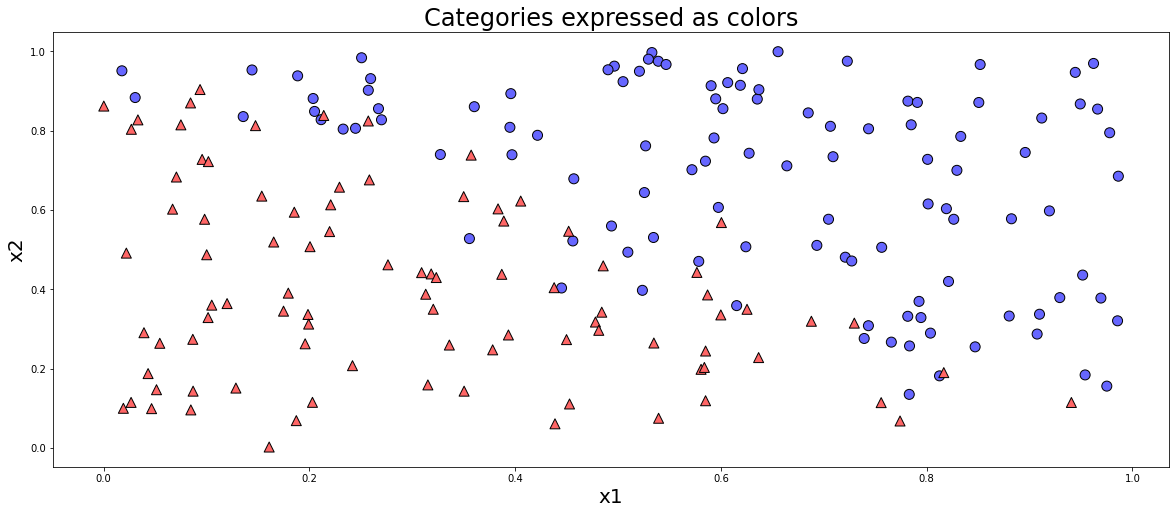

In [9]:
#@title Configure our example { run: "auto", display-mode: "form" }

# https://colab.research.google.com/notebooks/forms.ipynb

n = 200 #@param {type:"slider", min:1, max:1000, step:1}
m = -1 #@param {type:"slider", min:-10, max:10, step: 0.1}
b = 1 #@param {type:"slider", min:-10, max:10, step: 0.1}

noise_level = 0.1 #@param {type:"slider", min:0.0, max:1.0, step:0.1}

title = 'Categories expressed as colors' #@param {type:"string"}
dim_1_label = 'x1' #@param {type:"string"}
dim_2_label = 'x2' #@param {type:"string"}

import pandas as pd
import numpy as np

# np.random.seed(42)

# all points
X = np.random.uniform(0, 1, (n, 2))

# below or above line determines which category they belong to (plus noise)
noise = np.random.normal(0, noise_level, n)
y_bool = X[:, 1] > m*X[:, 0]+b + noise
y = y_bool.astype(int)

plt.xlabel(dim_1_label)
plt.ylabel(dim_2_label)
plt.title(title)

size=100

from matplotlib.colors import ListedColormap
cmap = ListedColormap(['#FF6666', '#6666FF'])

plt.scatter(X[:,0], X[:,1], c=y, cmap=cmap, marker='o', edgecolors='k', s=y*size);
plt.scatter(X[:,0], X[:,1], c=y, cmap=cmap, marker='^', edgecolors='k', s=~y_bool*size);

x = tf.constant(X, dtype='float32')
y_true = tf.constant(y, dtype='float32')

def plot_decision_boundaries(model, X, y_true):
  _, ax = plt.subplots(figsize=(8,4), dpi=300)

  clfviz_bivar(
              model, X, y_true, 
             show=['instances', 'boundaries', 'probabilities', 'misclassified'],
             markers=['^','o'],
             ntiles=50, 
             ax=ax,
             tile_fraction=1.0, 
             boundary_markersize=1.0,
             feature_names=[dim_1_label, dim_1_label],
             colors={'class_boundary': 'black',
                     'tile_alpha': 0.5,
                     'warning' : 'yellow',
                     'classes':
                         [None,  # 0 classes
                          None,  # 1 class
                          ['#FF6666', '#6666FF'],  # 2 classes
                          ]})

# Shared Exercise
## Can you think of an application for this? What could be on the axes?

_Let's adapt the example to something we can relate to_

### We have two dimensions as input

In [10]:
x = tf.constant(X, dtype='float32')
y_true = tf.constant(y, dtype='float32')

X.shape, y.shape

((200, 2), (200,))

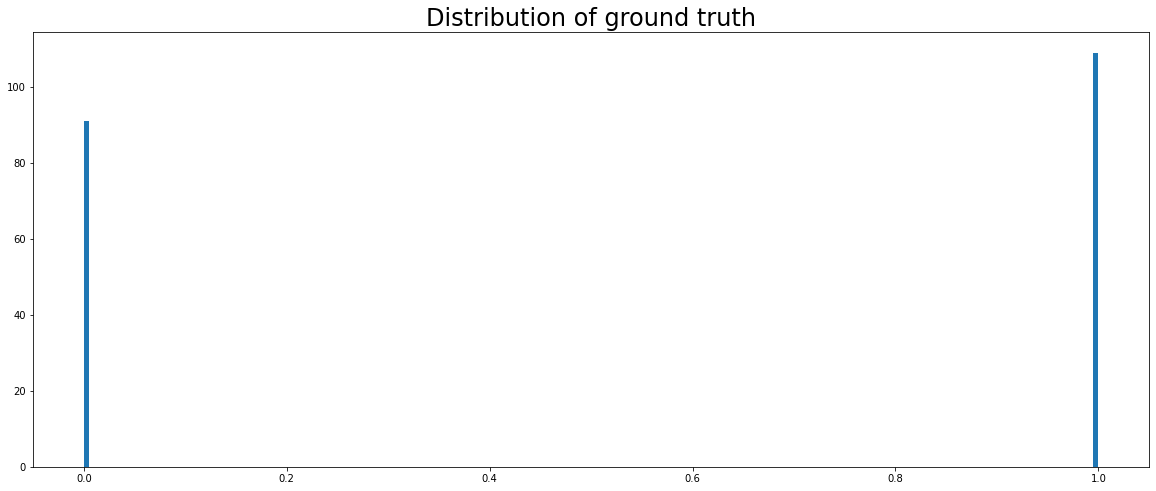

In [11]:
plt.hist(y, bins=n)
plt.title('Distribution of ground truth');

# Model

## We model this as a linear problem

<img src='https://djcordhose.github.io/ml-workshop/img/neuron-v2.png'>

In [12]:
from tensorflow.keras.layers import Dense
 
model = tf.keras.Sequential()
model.add(Dense(units=1, input_dim=2))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [13]:
y_pred = model.predict(x)
y_pred.shape

(200, 1)

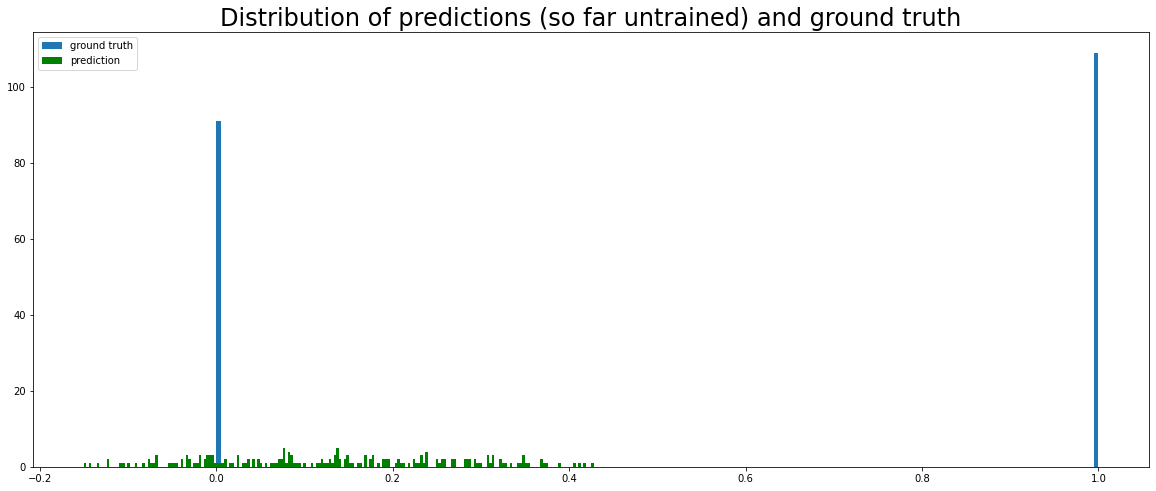

In [14]:
plt.hist(y, bins=n)
plt.hist(y_pred, bins=n, color='green')

plt.legend(['ground truth', 'prediction'])
plt.title('Distribution of predictions (so far untrained) and ground truth');

## Turning a value between 0 and 1 into a binary decision

In [15]:
# y_pred

In [16]:
threshold = 0.5

In [17]:
y_pred_binary = (y_pred > threshold).astype(int).ravel()
y_pred_binary

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


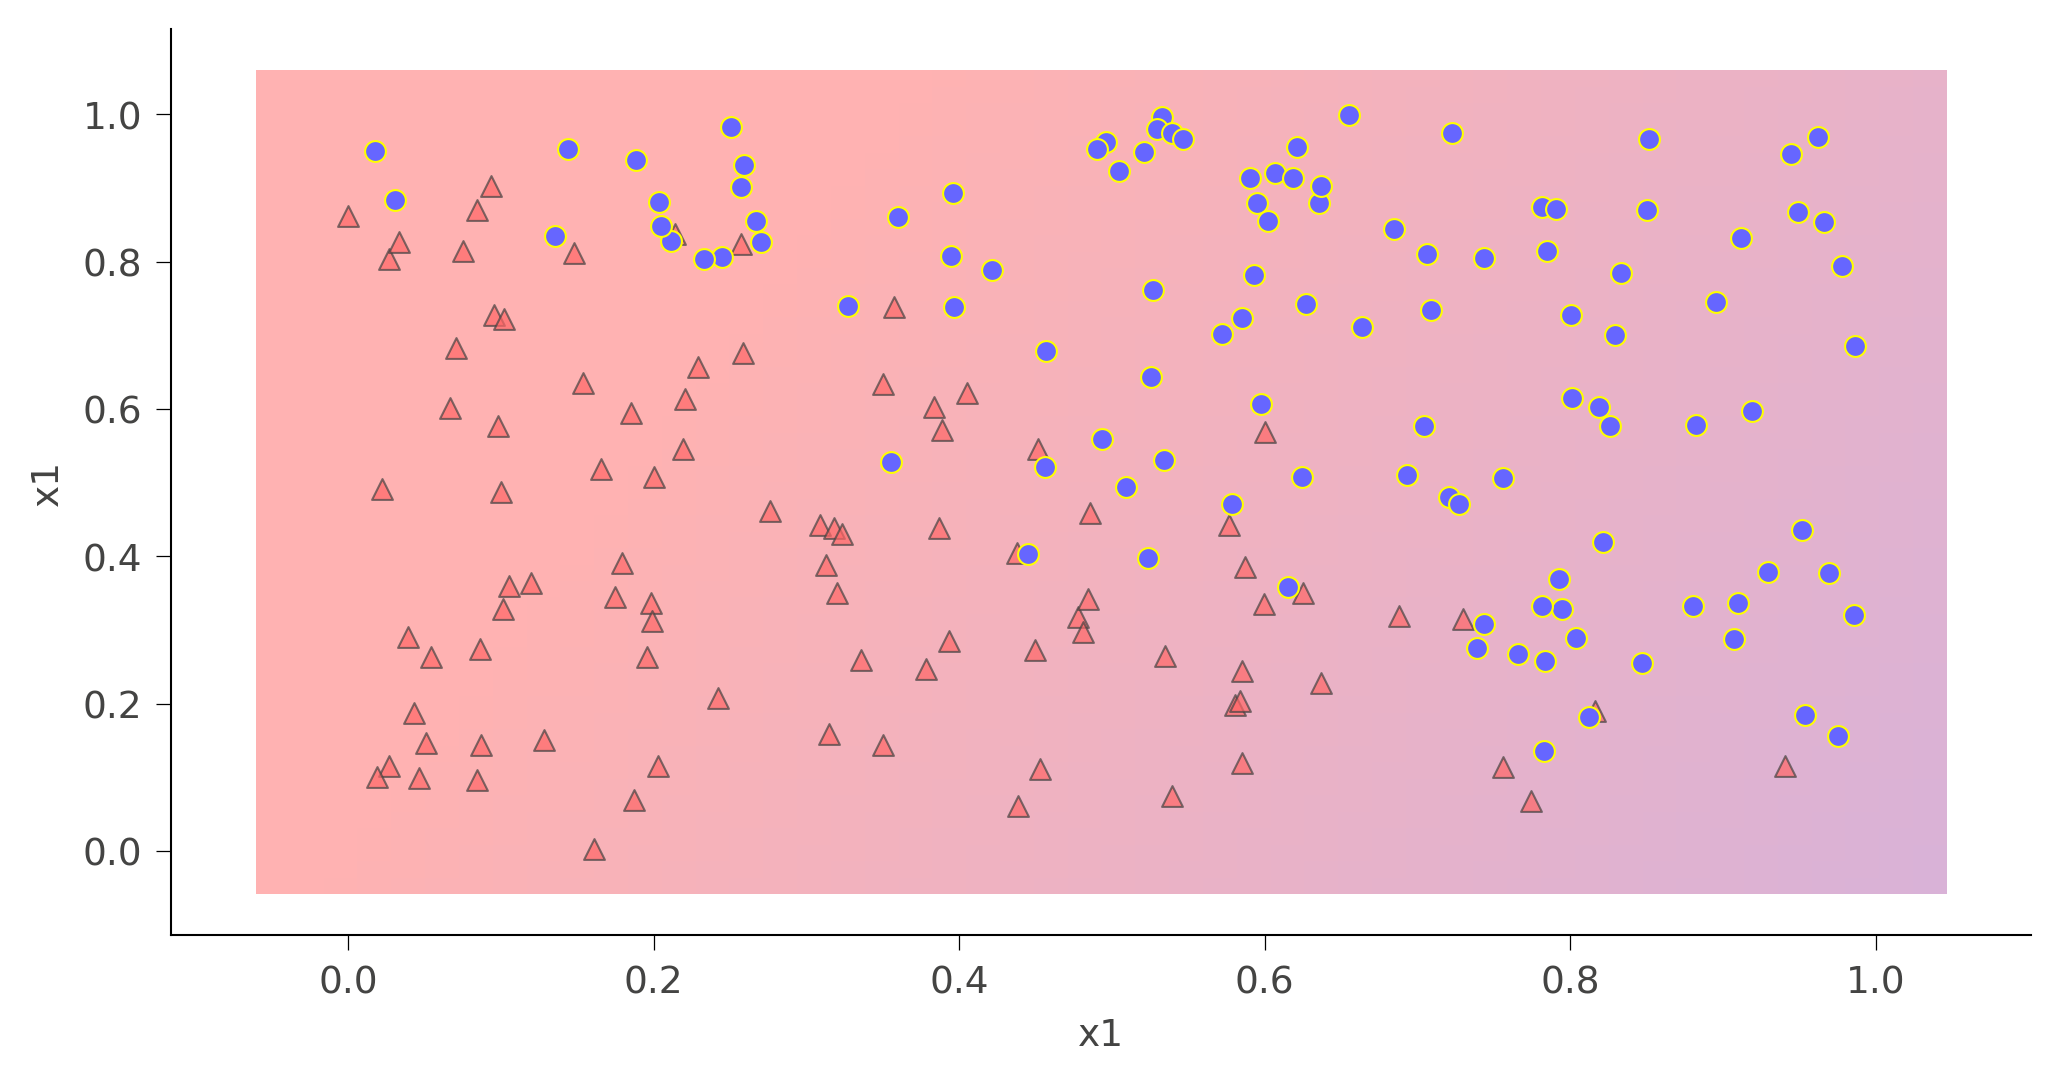

In [18]:
plot_decision_boundaries(model, X, y_true)

# Metrics

We know our model is wrong, but by how much?

## Mean Squared Error

emphasizes larger errors

$MSE = {\frac {1}{n}}\sum _{i=1}^{n}(Y_{i}-{\hat {Y_{i}}})^{2}$


https://en.wikipedia.org/wiki/Mean_squared_error


In [19]:
tf.losses.mean_squared_error(y_true=tf.squeeze(y), y_pred=tf.squeeze(y_pred)).numpy()

0.38606715

## Accuracy: what share of predictions is correct?

* basic metric for classification: share of correctly predicted samples
* https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/metrics/Accuracy


In [20]:
accuracy = tf.keras.metrics.Accuracy()
accuracy.update_state(y, y_pred_binary)
accuracy.result().numpy()

0.455

In [21]:
# same, but includes the thresholding, y_pred instead of y_pred_binary

accuracy = tf.keras.metrics.BinaryAccuracy()
accuracy.update_state(y, y_pred)
accuracy.result().numpy()

0.455

# Training

In [22]:
%%time 

model.compile(loss='mse', 
             optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x, y_true, epochs=1500, verbose=0)

CPU times: user 14.6 s, sys: 893 ms, total: 15.5 s
Wall time: 21 s


In [23]:
loss, accuracy = model.evaluate(x, y_true, verbose=0)
loss, accuracy

(0.10353054106235504, 0.8999999761581421)

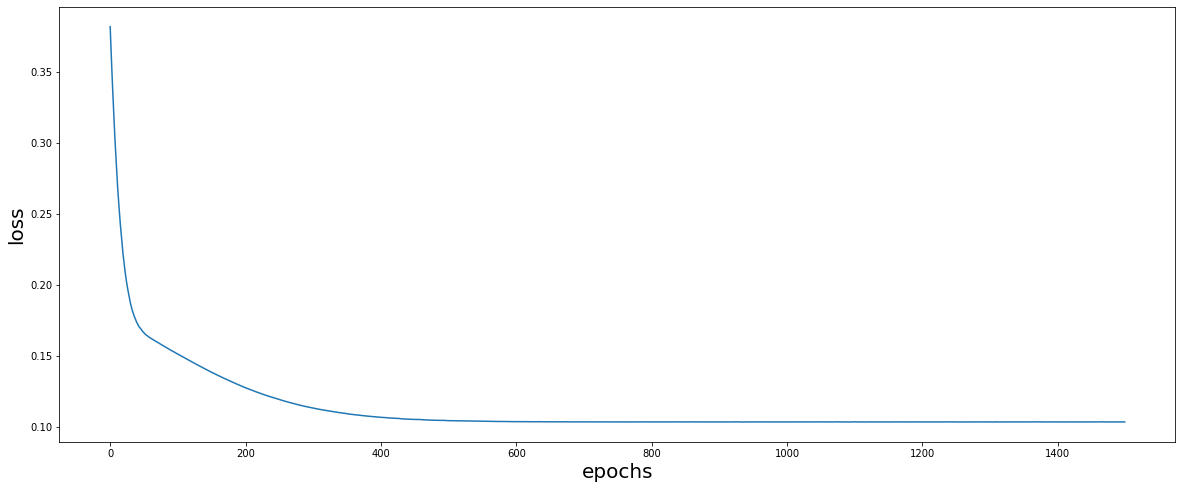

In [24]:
# plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")

plt.plot(history.history['loss']);

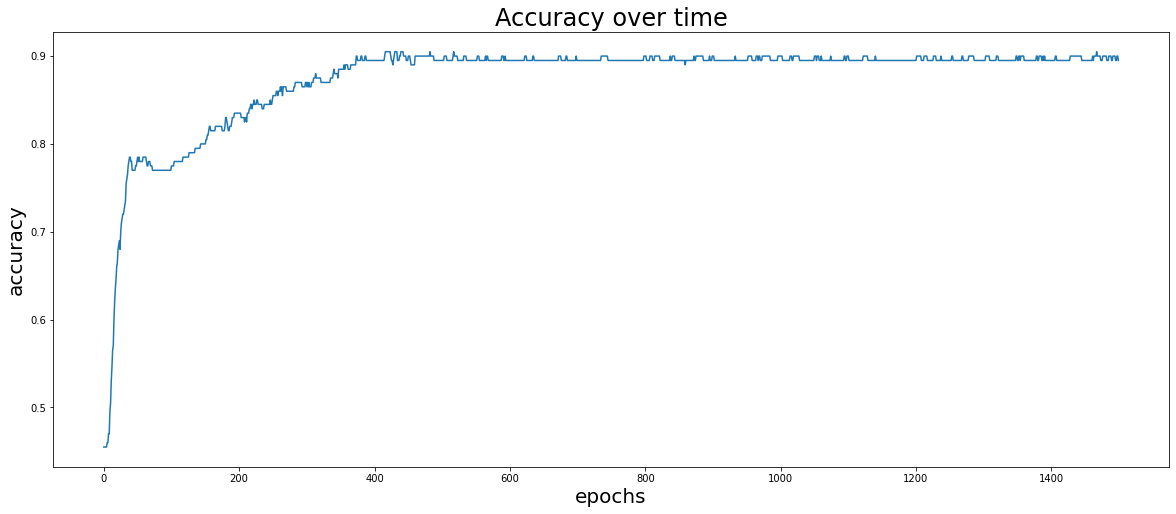

In [25]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over time')

plt.plot(history.history['accuracy']);

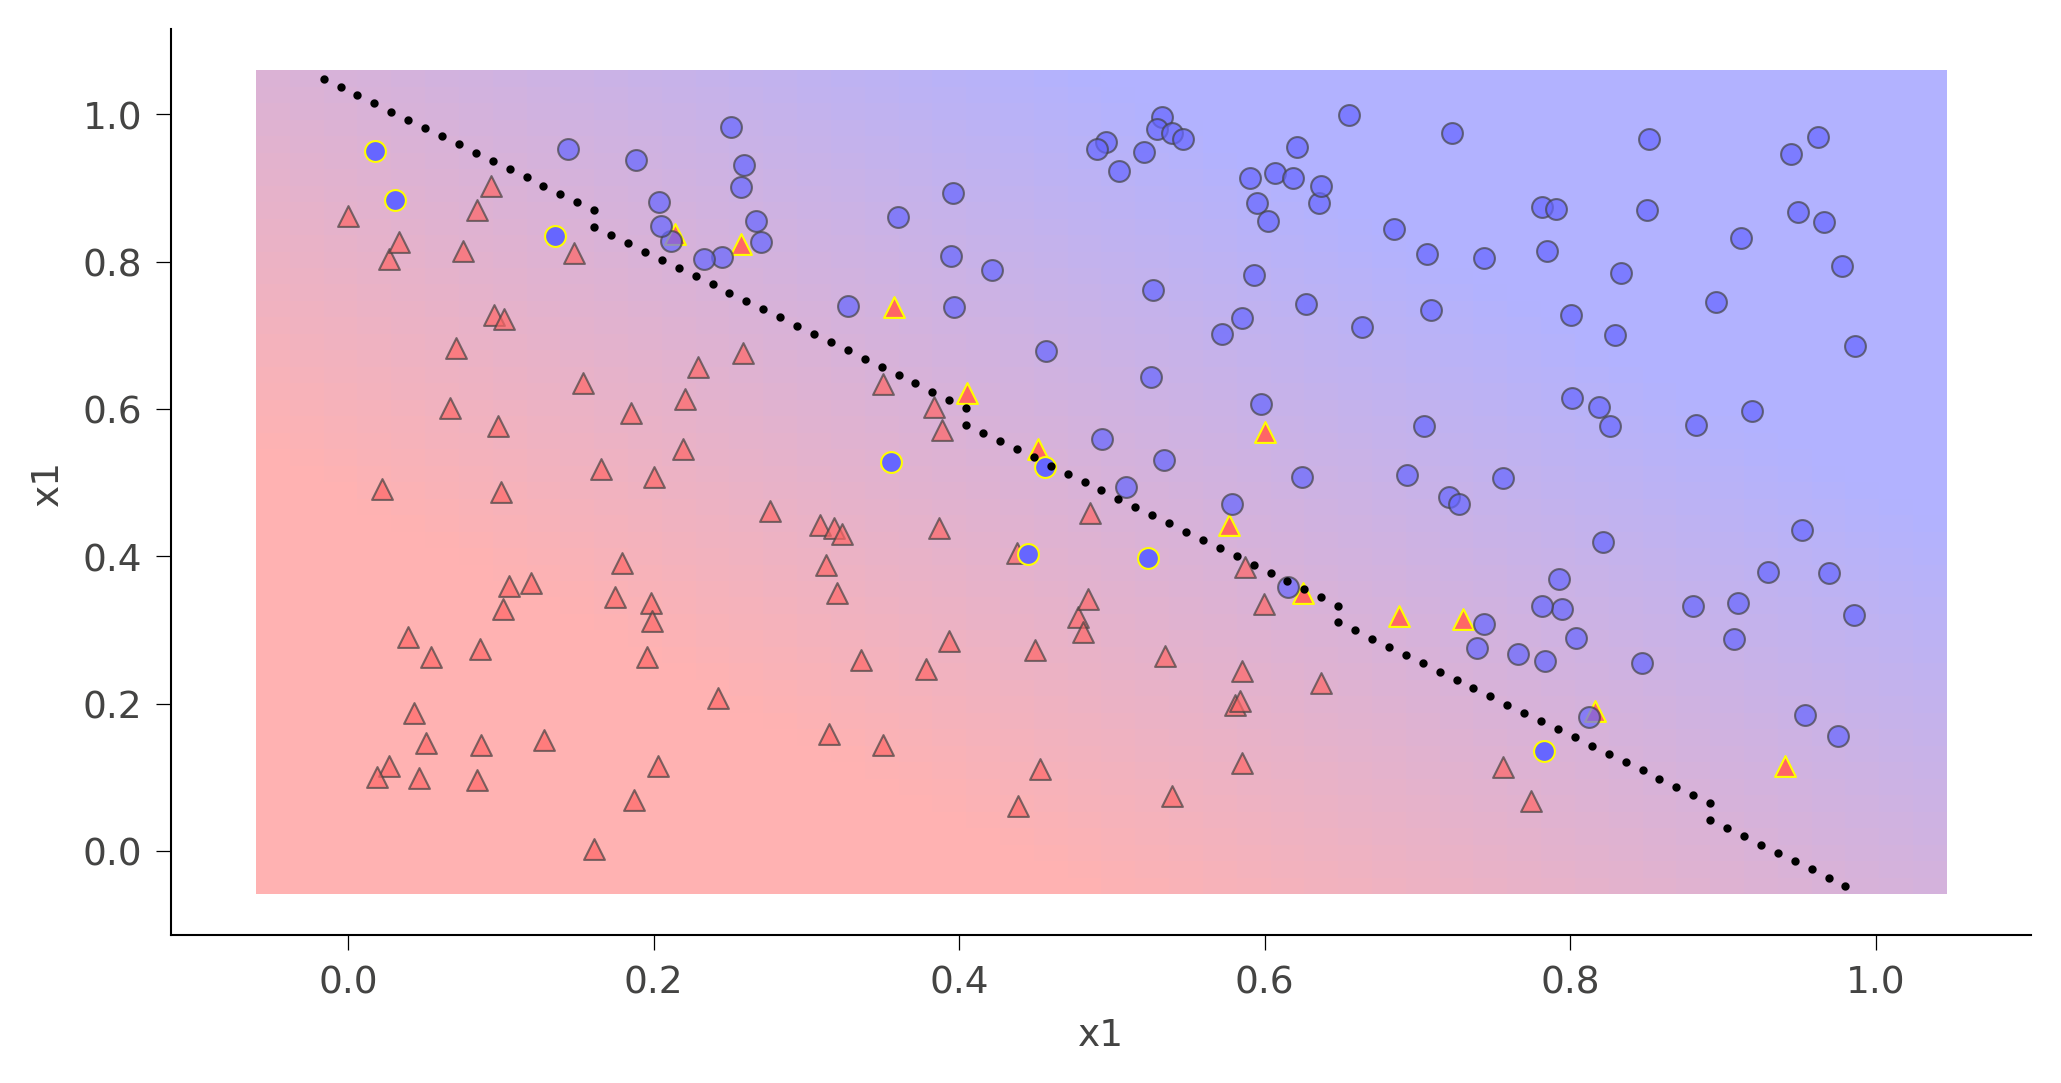

In [26]:
plot_decision_boundaries(model, X, y_true)

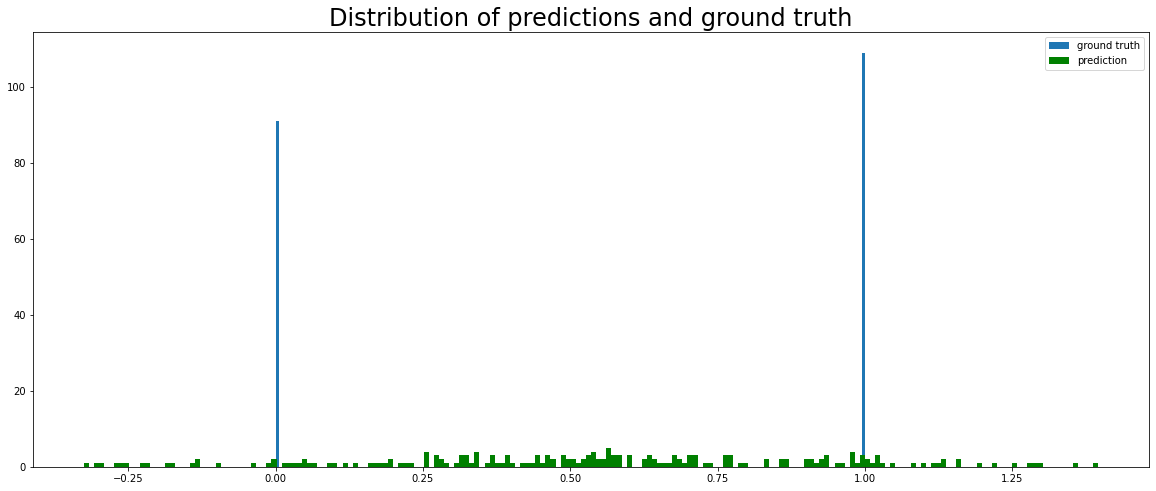

In [27]:
y_pred = model.predict(x)

plt.hist(y, bins=n)
plt.hist(y_pred, bins=n, color='green')

plt.legend(['ground truth', 'prediction'])
plt.title('Distribution of predictions and ground truth');

### Interpretation

* some values are negative
* some are above 1
* we have a lot of spread

# Logistic Regression


Typically, the output of a neuron is transformed using an activation function which compresses the output to a value between 0 and 1 (sigmoid), or between -1 and 1 (tanh) or sets all negative values to zero (relu).

<img src='https://djcordhose.github.io/ml-workshop/img/activation/neuron-sigmoid.png'>

### Typical Activation Functions

<img src='https://djcordhose.github.io/ml-workshop/img/activation/activation-functions.jpg'>

### We can use sigmoid as the activation function to compress prediction between 0 and 1

In [28]:
model = tf.keras.Sequential()
model.add(Dense(units=1, input_dim=2, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


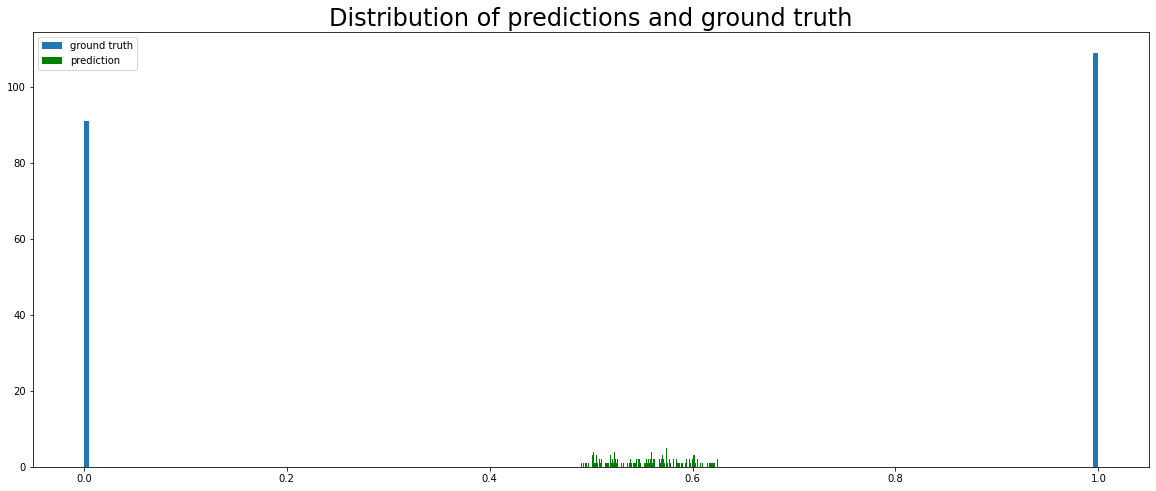

In [29]:
y_pred = model.predict(x)

plt.hist(y, bins=n)
plt.hist(y_pred, bins=n, color='green')

plt.legend(['ground truth', 'prediction'])
plt.title('Distribution of predictions and ground truth');

## Reconsidering the loss function


What makes a great loss function?
* you want the gradients to be steep, not shallow towards the minumum
* penalizes very confident misclassifications strongly 
* small errors need more shallow gradients
* perfect predictions need zero loss

## Ground Truth is either 0 or 1, prediction also between 0 and 1

https://www.geogebra.org/calculator/tx7ku7kg

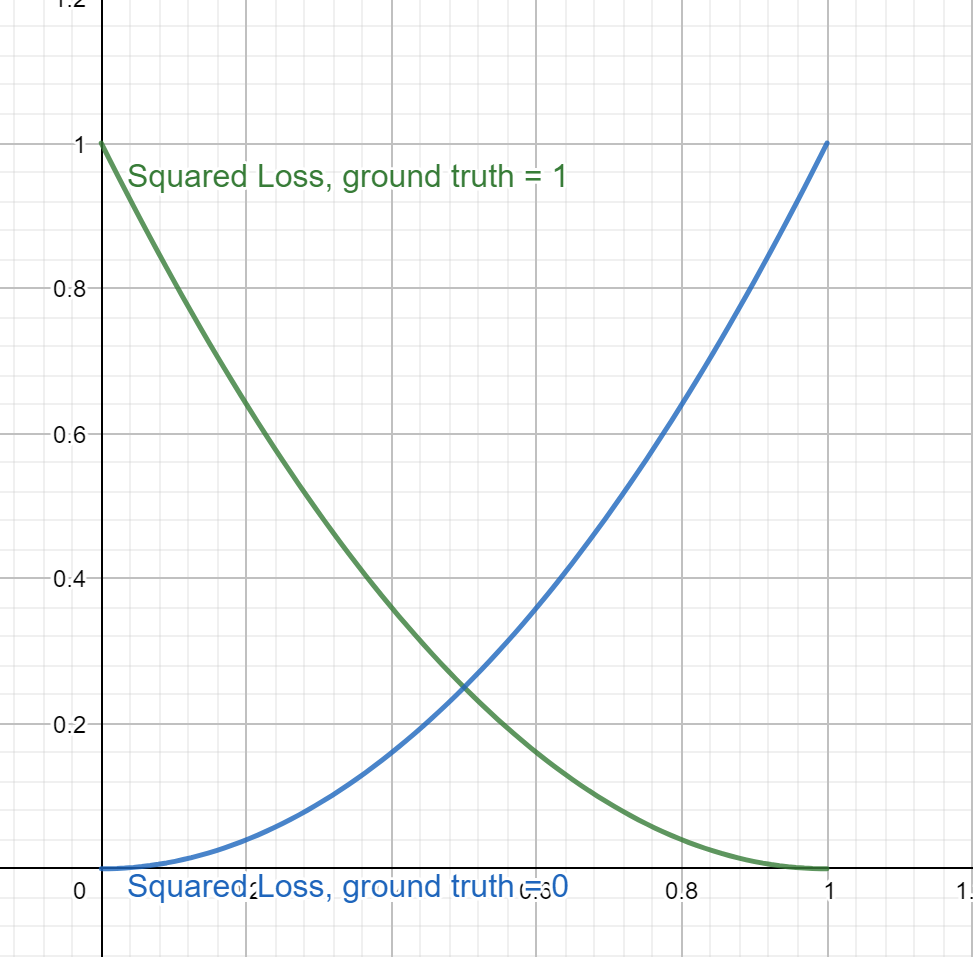

## How well is a squared error doing?
* how would you change the graph of the loss to have better properties?

### Binary Cross-Entropy / Log Loss

gives unbounded loss, $Y_{i}$ are assumed to only be 0 or 1

$xent = -{\frac {1}{n}}\sum _{i=1}^{n}(Y_{i} \cdot \ln{({\hat {Y_{i}}})}) + ((1-Y_{i}) \cdot \ln{(1 - {\hat {Y_{i}}})})$

__First term cancels out if ground truth $Y_{i}$ is 0, second if it is 1__

https://towardsdatascience.com/cross-entropy-for-classification-d98e7f974451

https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a



### Tool to explore loss functions

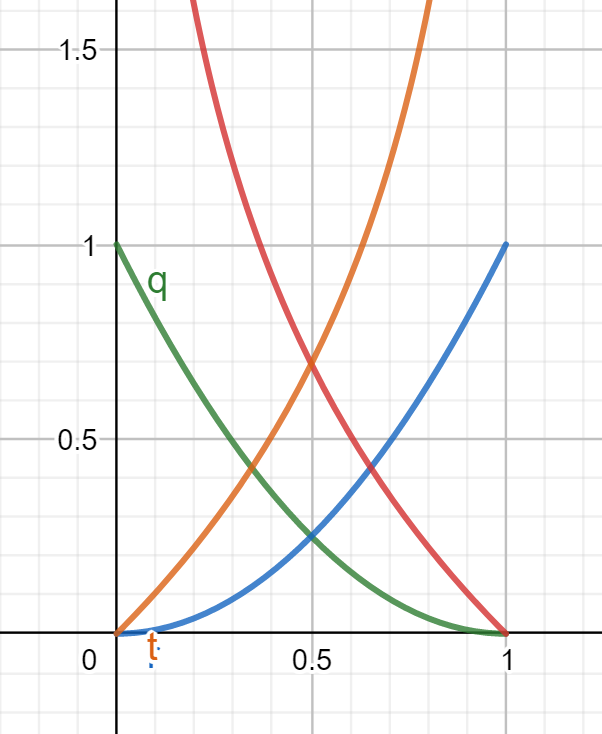

https://www.geogebra.org/calculator/tx7ku7kg


### binary cross-entropy / log loss as an alternative to mean squared error
* expects prediction to be between 0 and 1
* natural fit for sigmoid activation


In [30]:
# MSE will never be more than one
tf.losses.mean_squared_error(y_true=[[1], [1], [1]], y_pred=[[0.1], [0.01], [0.001]]).numpy()

array([0.80999994, 0.98010004, 0.99800104], dtype=float32)

In [31]:
# imperfections give unbounded losses (uses ln)
tf.losses.binary_crossentropy(y_true=[[1], [1], [1]], y_pred=[[0.1], [0.01], [0.001]]).numpy()

array([2.3025842, 4.60516  , 6.9076552], dtype=float32)

In [32]:
%%time 
 
model.compile(loss='binary_crossentropy', 
              optimizer='adam',
             metrics=['accuracy'])

history = model.fit(x, y_true, epochs=2000, verbose=0)

CPU times: user 20.6 s, sys: 1.23 s, total: 21.9 s
Wall time: 16.5 s


In [33]:
loss, accuracy = model.evaluate(x, y_true, verbose=0)
loss, accuracy

(0.30358776450157166, 0.8899999856948853)

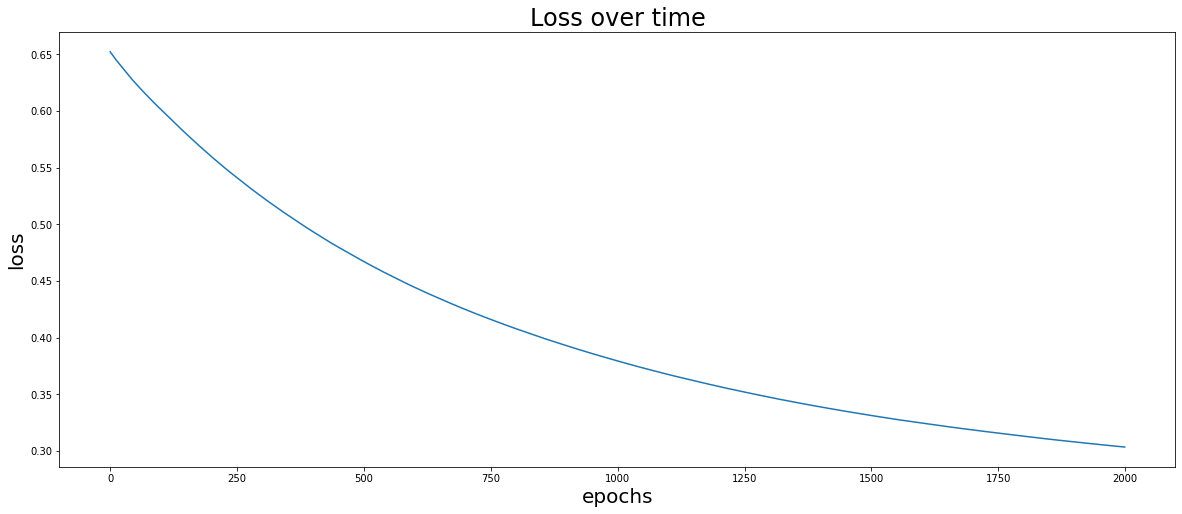

In [34]:
# plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over time')

plt.plot(history.history['loss']);

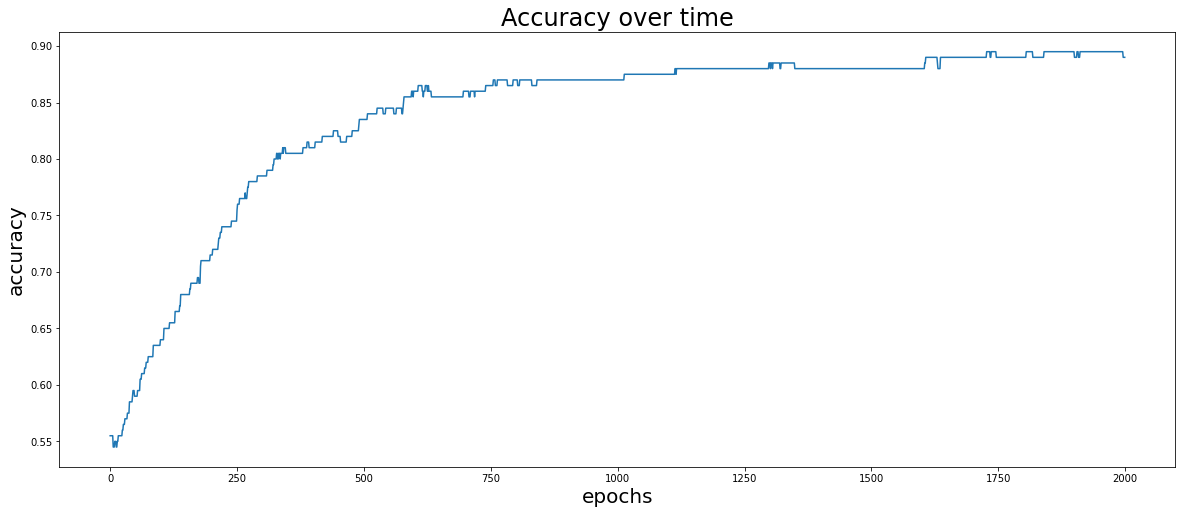

In [35]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over time')

plt.plot(history.history['accuracy']);

In [36]:
y_pred = model.predict(x)

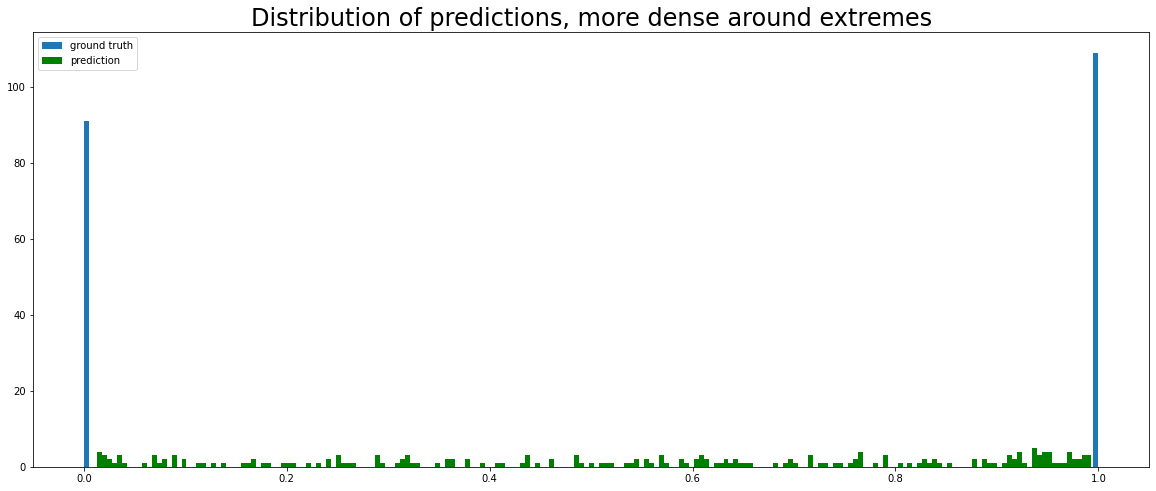

In [37]:
plt.hist(y, bins=n)
plt.hist(y_pred, bins=n, color='green')

plt.legend(['ground truth', 'prediction'])
plt.title('Distribution of predictions, more dense around extremes');

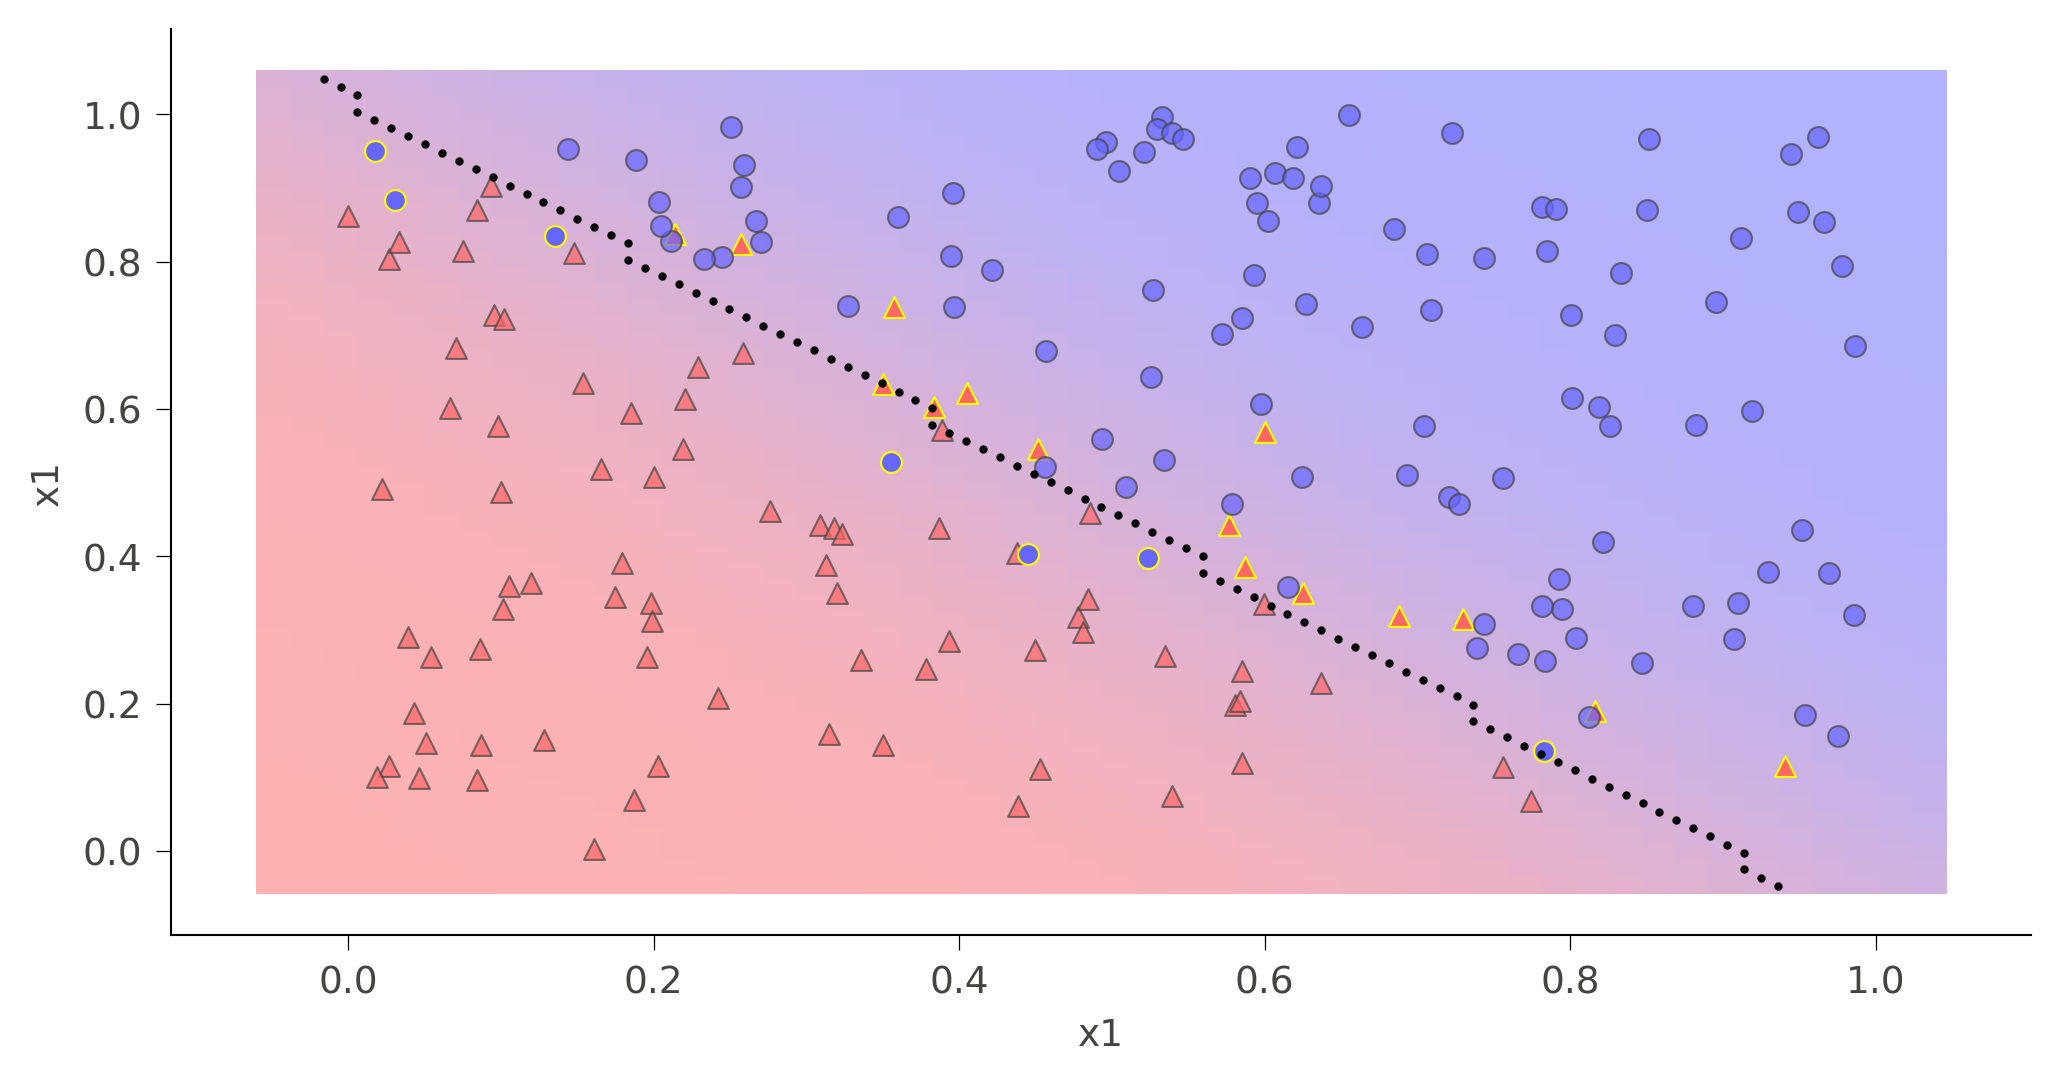

In [38]:
plot_decision_boundaries(model, X, y_true)

# Hands-On I: run this classification experiment

* generated your own dataset (maybe using a bit more noise)
* train the model and generate all the plots
* use both losses (MSE and xent) on the final model

# Deep Learning

Neural Networks with 2-3 Layers and non-linear activation can learn to draw any decision boundary or approximate any continuous function


## From single neuron to network in the TensorFlow Playground

<img src='https://djcordhose.github.io/ai/img/tf-plaground.png'>

https://playground.tensorflow.org/

## Interpration of Deep Learning

* the final layer combines all previous inputs into a single prediction
  * either a linear transformation or
  * a binary prediction or
  * a multi class prediction
* intermediate (hidden) layers transform the problem in way to make it linear or accessible to a logistic function
* ideally this replaces any manual feature engineering   

_deep learning with many hidden layers can be done for regression or classification alike_


In [39]:
model = tf.keras.Sequential()
model.add(Dense(units=100, input_dim=2, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 100)               300       
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 20,601
Trainable params: 20,601
Non-trainable params: 0
_________________________________________________________________


In [40]:
%%time 
 
model.compile(loss='binary_crossentropy', 
              optimizer='adam',
             metrics=['accuracy'])

history = model.fit(x, y_true, epochs=1500, verbose=0)

CPU times: user 24.7 s, sys: 1.94 s, total: 26.6 s
Wall time: 21 s


In [41]:
loss, accuracy = model.evaluate(x, y_true, verbose=0)
loss, accuracy

(0.1385575234889984, 0.9399999976158142)

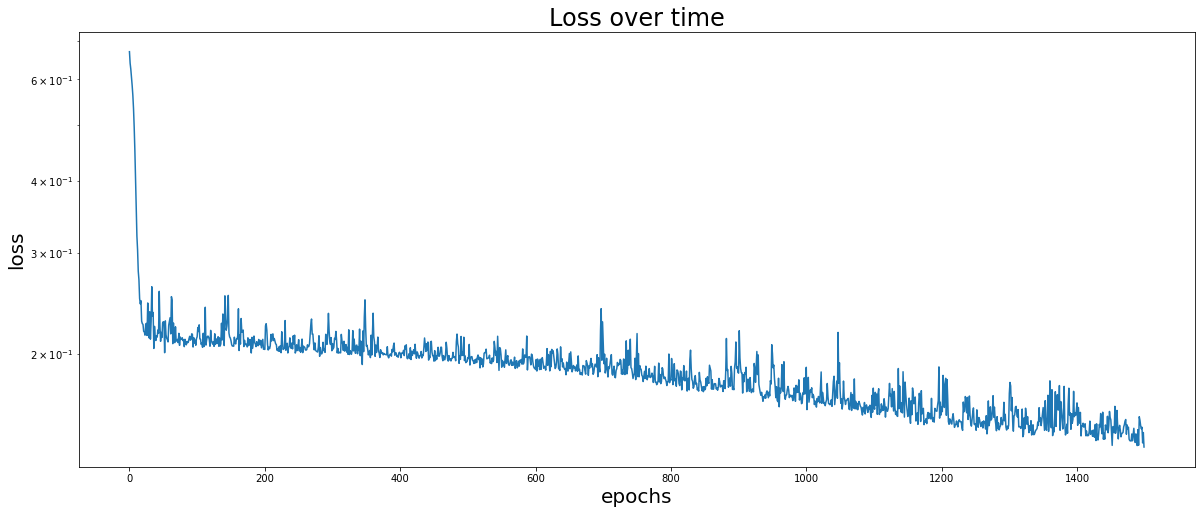

In [42]:
plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over time')

plt.plot(history.history['loss']);

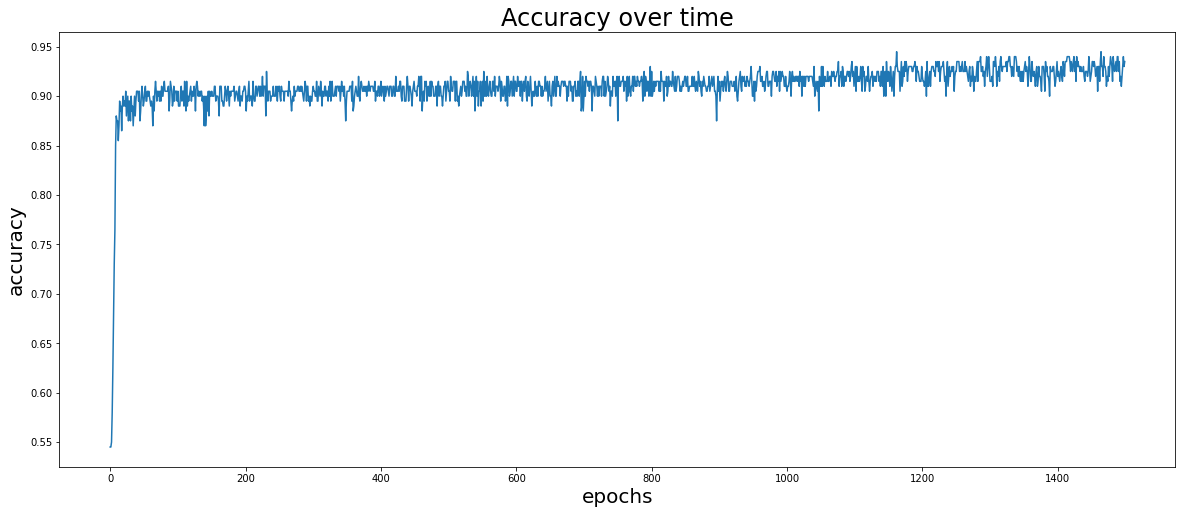

In [43]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over time')

plt.plot(history.history['accuracy']);

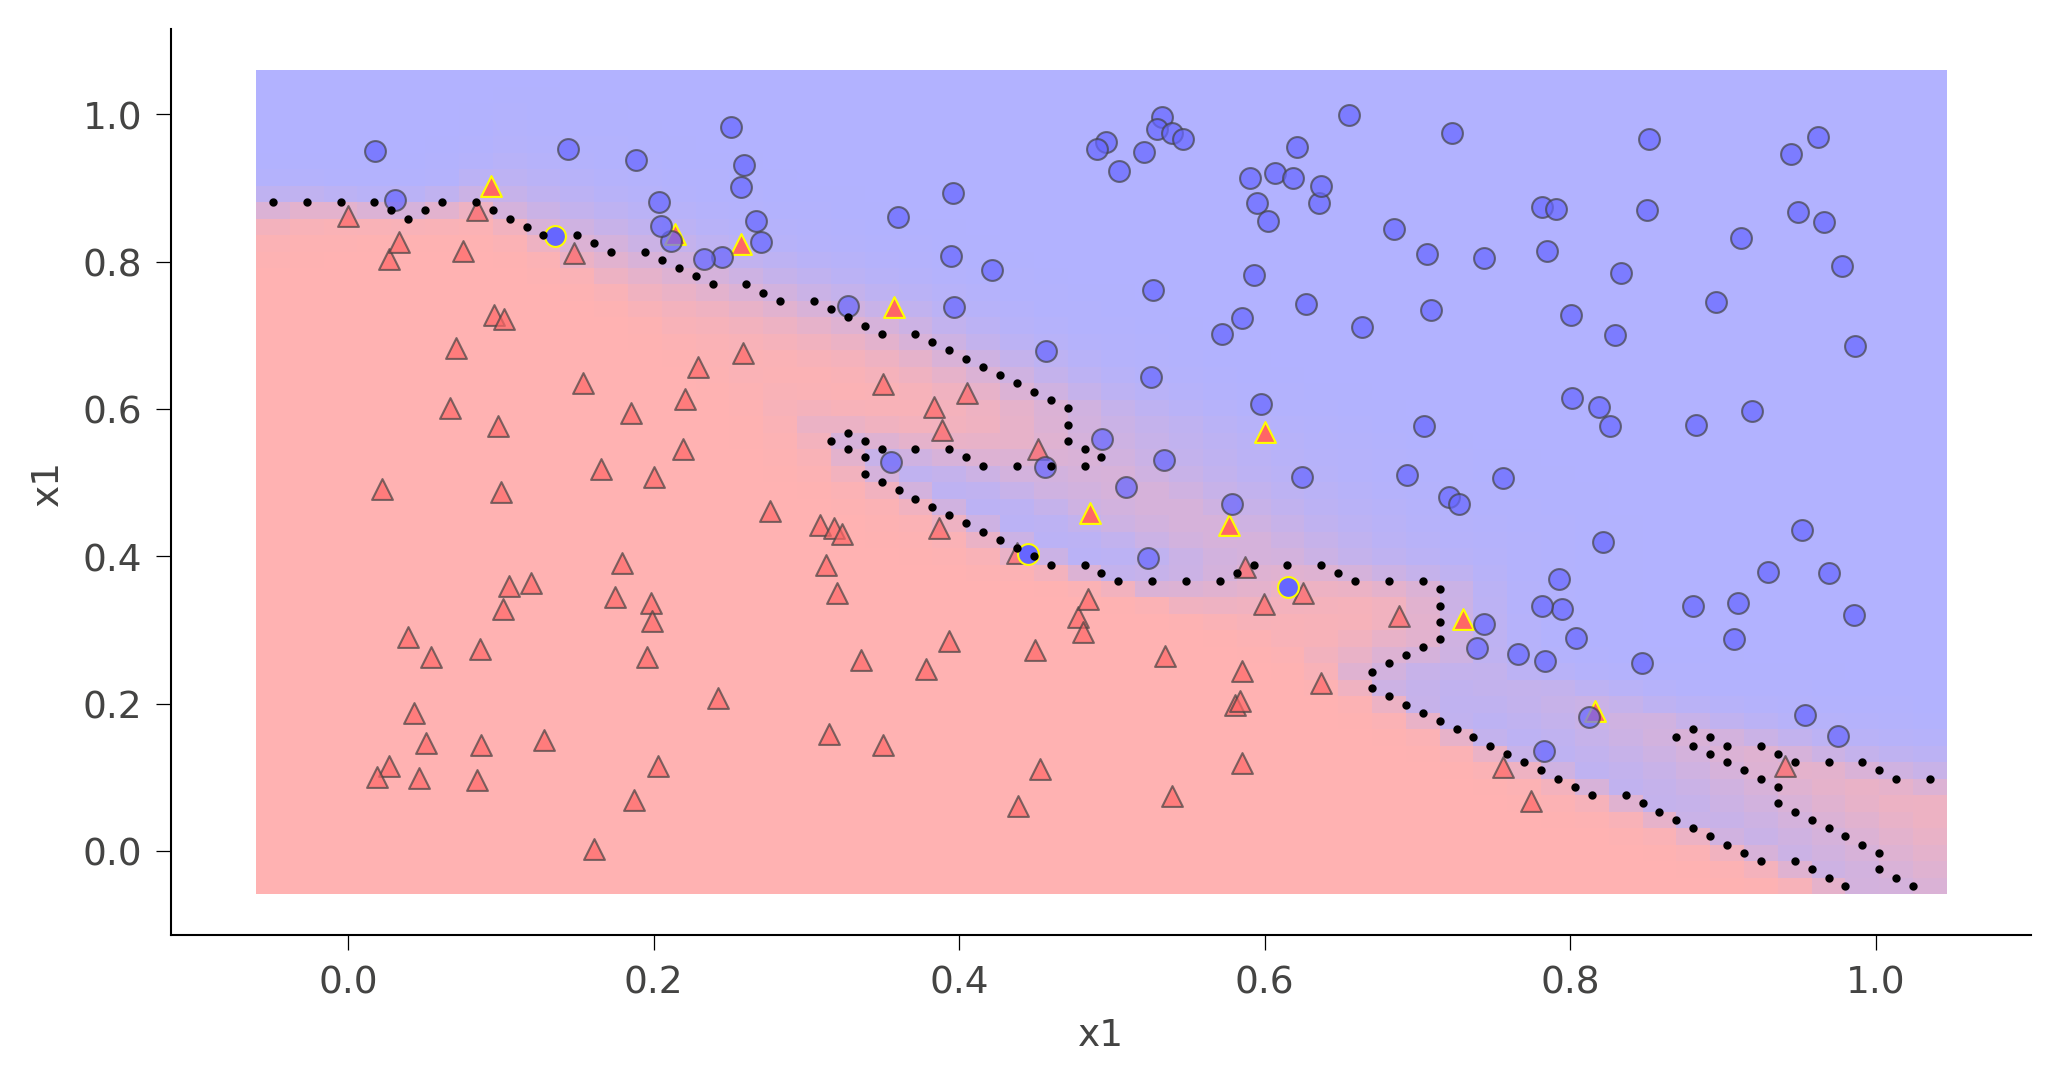

In [44]:
plot_decision_boundaries(model, X, y_true)

In [45]:
y_pred = model.predict(x)

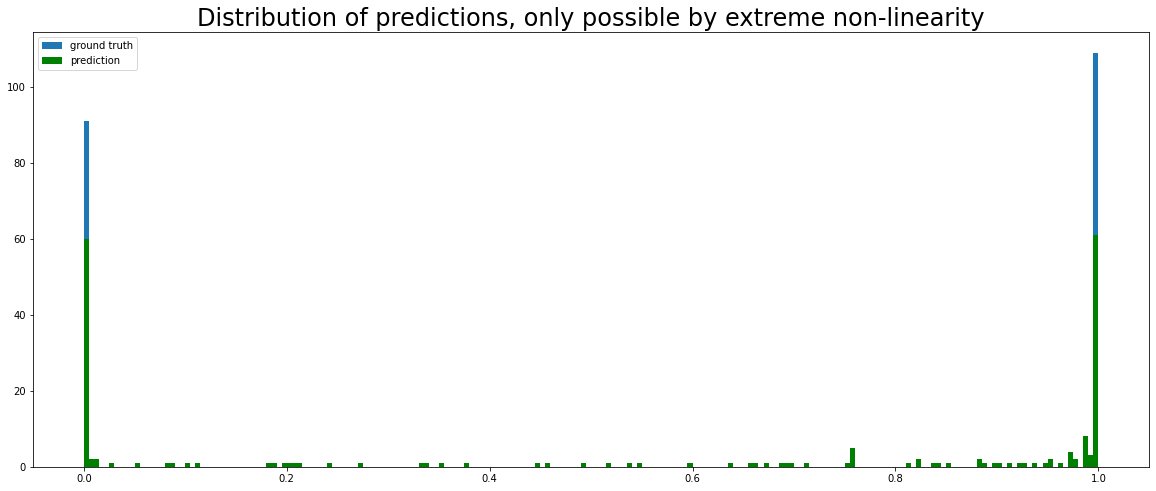

In [46]:
plt.hist(y, bins=n)
plt.hist(y_pred, bins=n, color='green')

plt.legend(['ground truth', 'prediction'])
plt.title('Distribution of predictions, only possible by extreme non-linearity');

# Hands-On II: Can you create a perfect model?

* use the playground to experiment with hidden layers
* under the hood the playground also uses a final neuron with tanh activation to decide between the two categories
* play with the existing model, 
  * add or remove layers
  * change number of neurons per layer
  * change number of epochs
  * change loss or activation
  * etc.

# Alternative Approach: one-hot encoding the prediction for multi-class prediction

* one output unit per category
* encoding of output is one-hot
* highest value (argmax) determines most likely class 
* softmax is a smooth version of argmax, its output can be interpreted as probabilities adding up to 1
* ideal with categorical crossentropy (not binary)
* multi-label output would be sigmoid with binary cross entropy, each output node would encode an hypothesis of its own, we just sum up all the errors

Sources:
* https://en.wikipedia.org/wiki/Cross_entropy 
* https://www.youtube.com/watch?v=ErfnhcEV1O8
* https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

In [47]:
model = tf.keras.Sequential()
model.add(Dense(units=100, input_dim=2, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=2, activation='softmax')) # the change is here
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 100)               300       
                                                                 
 dense_7 (Dense)             (None, 100)               10100     
                                                                 
 dense_8 (Dense)             (None, 100)               10100     
                                                                 
 dense_9 (Dense)             (None, 2)                 202       
                                                                 
Total params: 20,702
Trainable params: 20,702
Non-trainable params: 0
_________________________________________________________________


In [48]:
%%time 
 
model.compile(loss='sparse_categorical_crossentropy',  # the change is here
              optimizer='adam',
             metrics=['accuracy'])

history = model.fit(x, y_true, epochs=1500, verbose=0)

CPU times: user 23.9 s, sys: 1.89 s, total: 25.8 s
Wall time: 18.1 s


In [49]:
loss, accuracy = model.evaluate(x, y_true, verbose=0)
loss, accuracy

(0.11381259560585022, 0.9449999928474426)

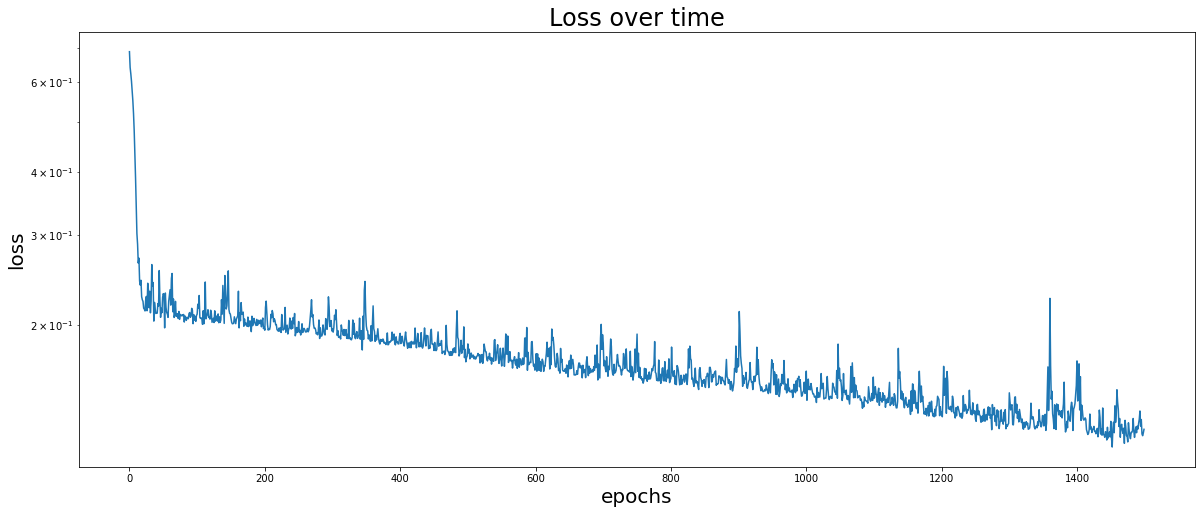

In [50]:
plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over time')

plt.plot(history.history['loss']);

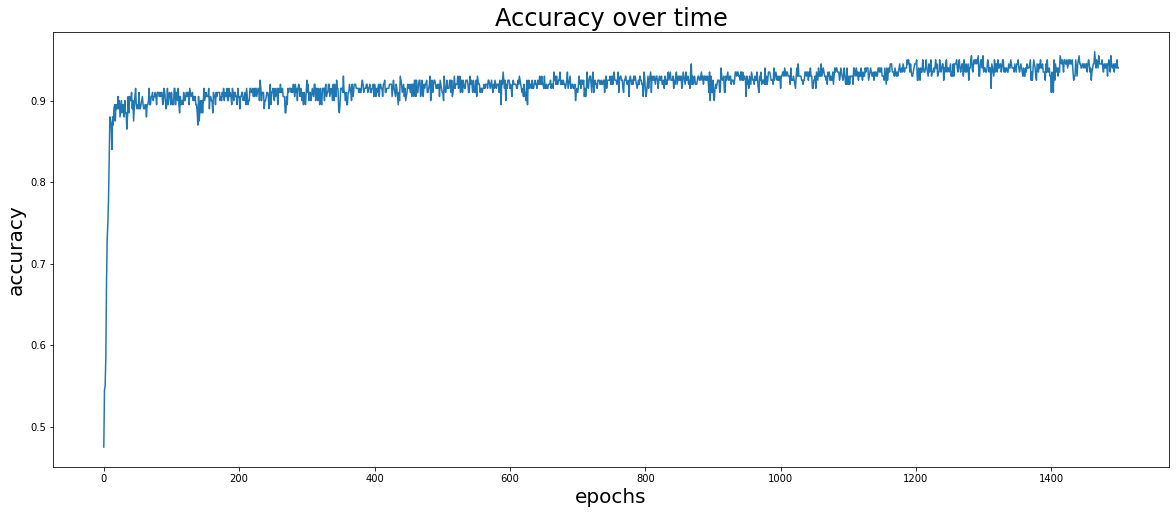

In [51]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over time')

plt.plot(history.history['accuracy']);

In [52]:
y_pred = model.predict(x)
y_pred_binary = y_pred.argmax(axis=1) # new way of determining the prediction
y_pred.shape, y_pred_binary.shape

((200, 2), (200,))

In [53]:
y_one_hot = tf.one_hot(y, 2)
y.shape, y_one_hot.shape

((200,), TensorShape([200, 2]))

In [54]:
accuracy = tf.keras.metrics.CategoricalAccuracy()
accuracy.update_state(y_one_hot, y_pred)
accuracy.result().numpy()

0.945

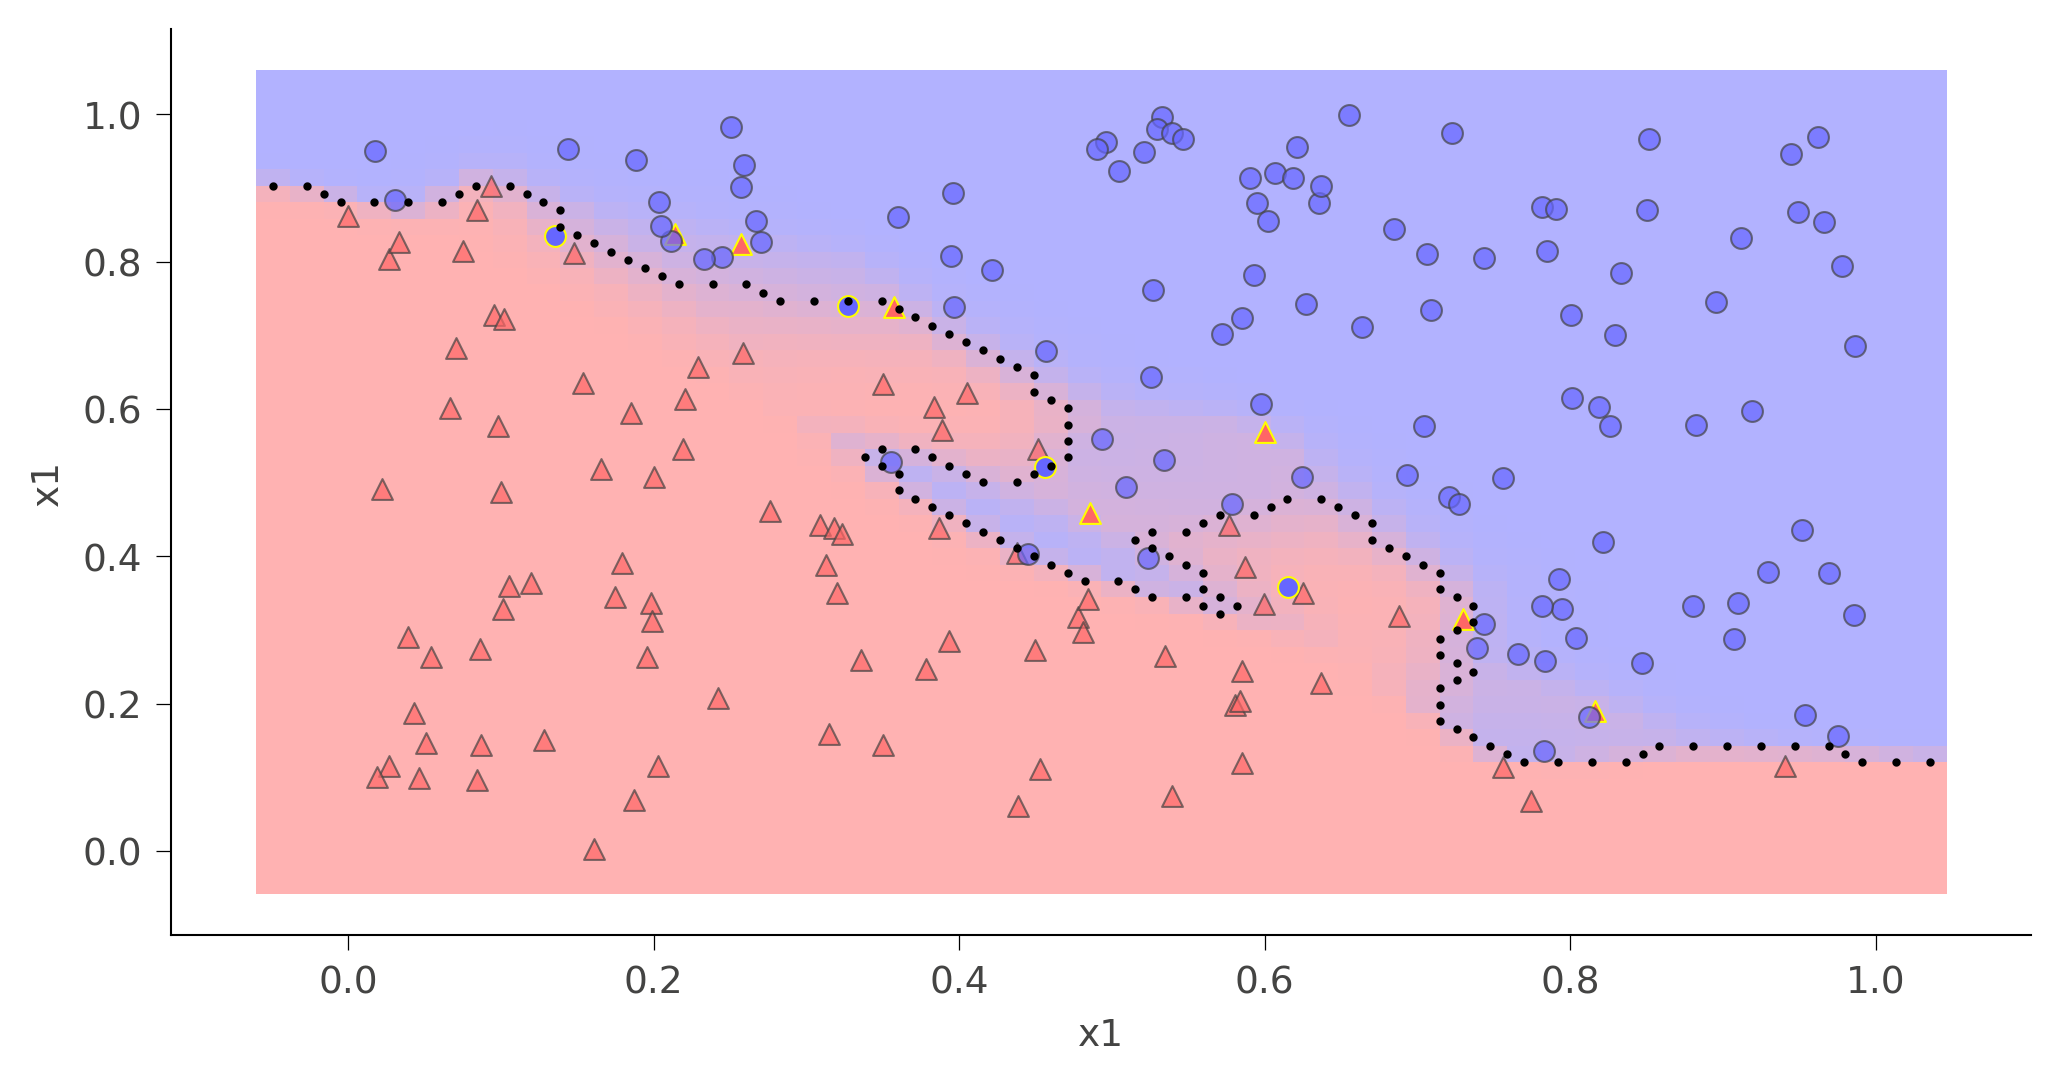

In [55]:
plot_decision_boundaries(model, X, y_true)

# Alternative Approach #2: multi label prediction with separate hypothesisses and probabilities


In [56]:
model = tf.keras.Sequential()
model.add(Dense(units=100, input_dim=2, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=2, activation='sigmoid')) # again, the change is here
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 100)               300       
                                                                 
 dense_11 (Dense)            (None, 100)               10100     
                                                                 
 dense_12 (Dense)            (None, 100)               10100     
                                                                 
 dense_13 (Dense)            (None, 2)                 202       
                                                                 
Total params: 20,702
Trainable params: 20,702
Non-trainable params: 0
_________________________________________________________________


In [57]:
y_true_one_hot = tf.one_hot(tf.cast(y_true, dtype='int32'), depth=2)
y_true_one_hot.shape

TensorShape([200, 2])

In [58]:
%%time 
 
model.compile(loss='binary_crossentropy', # changing back to original loss
              optimizer='adam',
             metrics=['accuracy'])

history = model.fit(x, y_true_one_hot, epochs=1500, verbose=0)

CPU times: user 25.1 s, sys: 1.9 s, total: 27 s
Wall time: 21 s


In [59]:
loss, accuracy = model.evaluate(x, y_true_one_hot, verbose=0)
loss, accuracy

(0.1516583263874054, 0.9350000023841858)

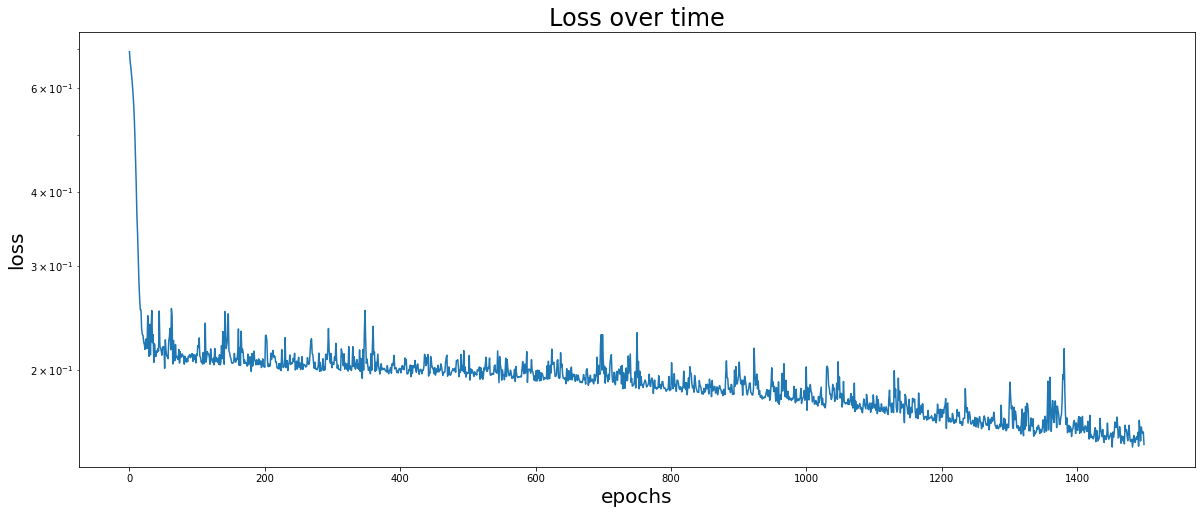

In [60]:
plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over time')

plt.plot(history.history['loss']);

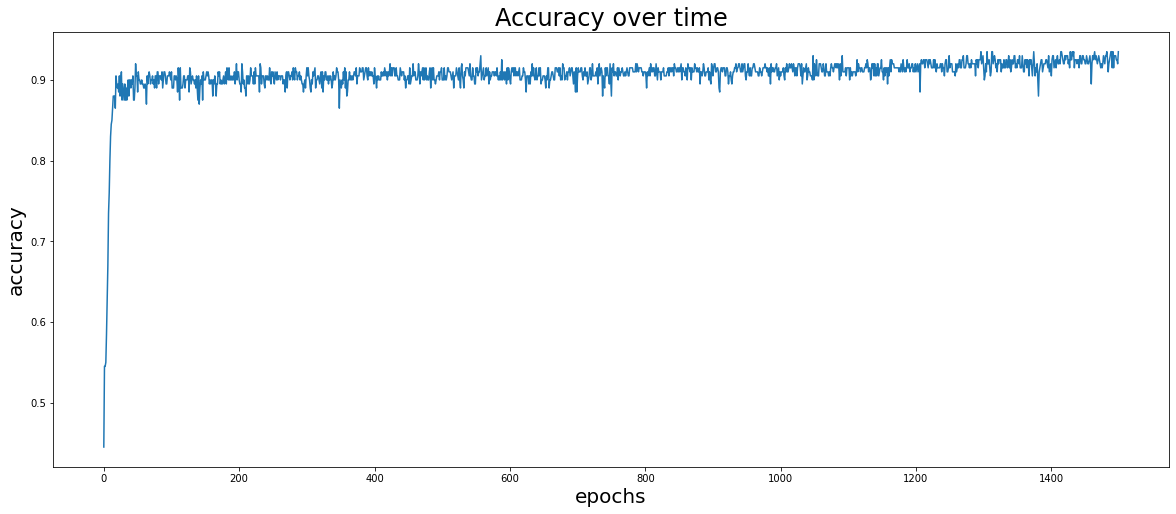

In [61]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over time')

plt.plot(history.history['accuracy']);

In [62]:
y_pred = model.predict(x)
y_pred_binary = y_pred.argmax(axis=1) # new way of determining the prediction
y_pred.shape, y_pred_binary.shape

((200, 2), (200,))

In [63]:
y_one_hot = tf.one_hot(y, 2)
y.shape, y_one_hot.shape

((200,), TensorShape([200, 2]))

In [64]:
accuracy = tf.keras.metrics.CategoricalAccuracy()
accuracy.update_state(y_one_hot, y_pred)
accuracy.result().numpy()

0.935

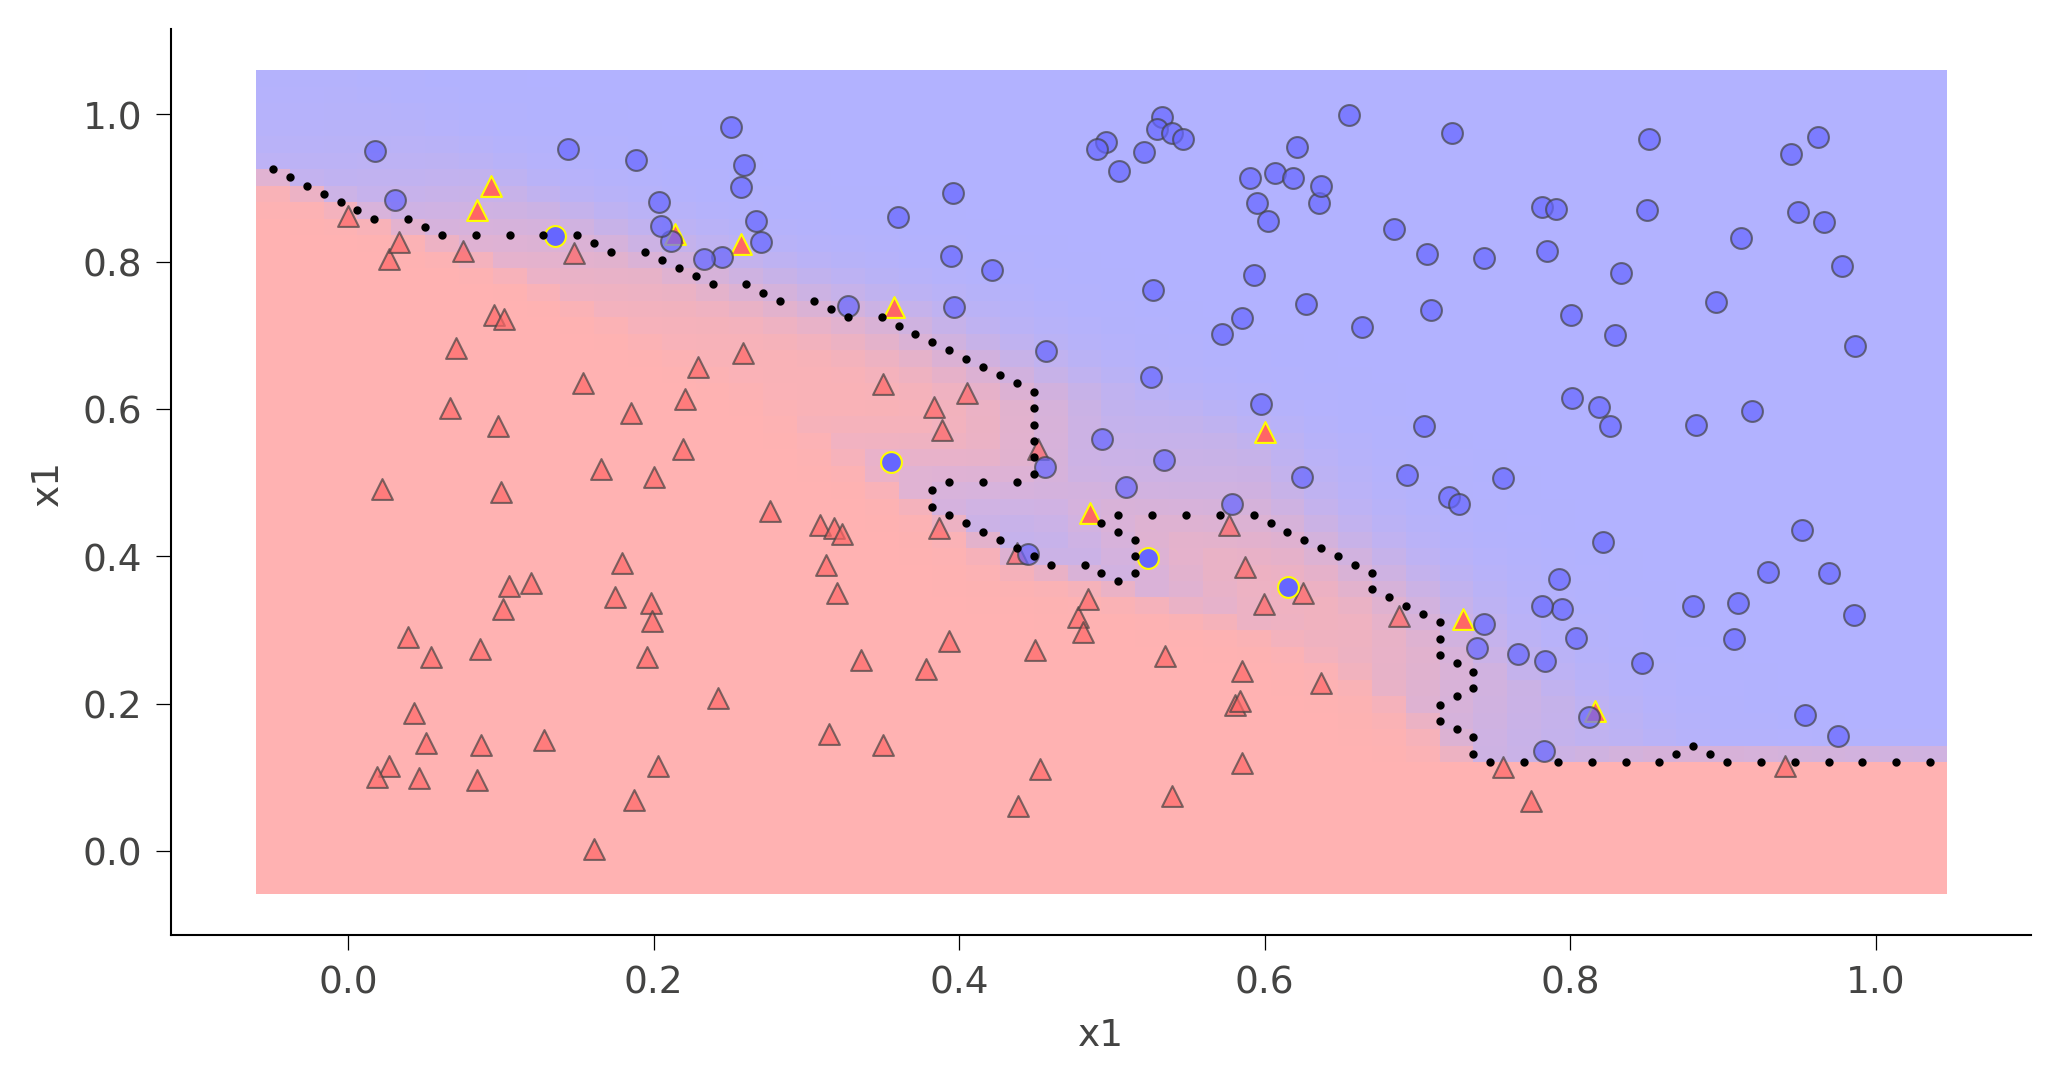

In [65]:
plot_decision_boundaries(model, X, y_true)

## Confusion Matrix

In [66]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

gt_labels = ['0 / red (true)', '1 / blue (true)']
dt_labels = ['0 / red (predicted)', '1 / blue (predicted)']
def plot_cm(model, X, y):
  y_pred = model.predict(X).argmax(axis=1)
  cm = confusion_matrix(y, y_pred)
  figure = plt.figure(figsize=(10, 10))

  sns.heatmap(cm, annot=True, xticklabels=dt_labels, yticklabels=gt_labels, cmap='Blues', fmt='d')

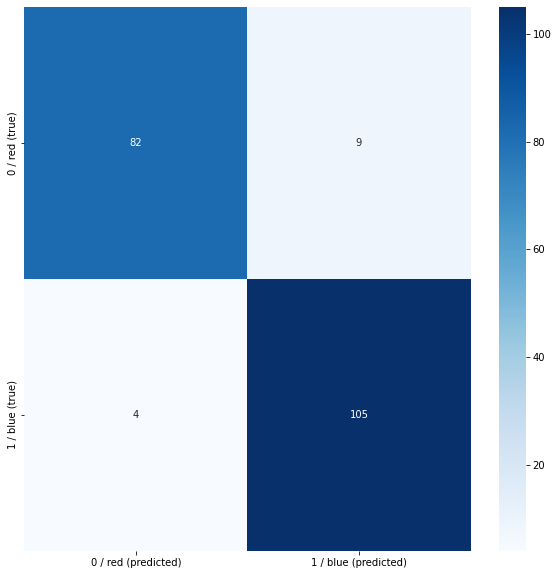

In [67]:
plot_cm(model, X, y)

# Saving and loading model

In [68]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 100)               300       
                                                                 
 dense_11 (Dense)            (None, 100)               10100     
                                                                 
 dense_12 (Dense)            (None, 100)               10100     
                                                                 
 dense_13 (Dense)            (None, 2)                 202       
                                                                 
Total params: 20,702
Trainable params: 20,702
Non-trainable params: 0
_________________________________________________________________


In [69]:
# https://www.tensorflow.org/guide/keras/save_and_serialize
model.save('classifier.h5')

In [70]:
!ls -lh

total 288K
-rw-r--r-- 1 root root 281K Jan 23 17:03 classifier.h5
drwxr-xr-x 1 root root 4.0K Jan  7 14:33 sample_data


In [71]:
loaded_model = tf.keras.models.load_model('classifier.h5')

In [72]:
y_pred = loaded_model.predict(x)
y_pred_binary = y_pred.argmax(axis=1) # new way of determining the prediction
y_pred_binary

array([1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 0])